### Todo MVP2, study how to simply answer to black opponent

[x] filter positions where black has to move
[x] refactor class MyGame into class ChessPosition  
[x] add comments in class ChessPosition  
[x] calculate multiplicity and probability of variations  

[x] refactor old analysis functions into class ChessPosition  
[] for every variation played by black calculate the answer advantage if white only learns to play that answer  
[] record the wab[1]  
[] record the associated sequence of two moves wstrategy[1]   
[] mvp2 tell wstrategy[1] of the Vienna game `1.e4 e5 2.Nc3 `

## Todo Debug and Test MVP1.5

[x] correct syntax error in class   
[x] parse database with new class  
[x] select 3 test positions  
[x] test reading functions  
    [x] test basic attributes
    [x] learn chess.svg.board
    [x] test counting attributes
[] test zeroth analysis functions  
[] test attack analysis functions  
[] test defense analysis functions  
[] test analysis database  

## Todo MVP1.5, prepare for more complexity

[x] make a plan to handle future features  
[x] implement attack strategy computation function  
[x] start implementation basic defence strategy computation  
[x] introduce future_advantages attribute  
[x] implement compute_future_advantages function  
[x] implement setup_study_branches function  
[x] implement order_study_branches function  
[x] implement study_one_more_node function  
[x] implement update_study_branches function  
[] implement estimate_upperbound_advantage function  
[x] introduce basic_strategy_encoded attribute
[x] implement update_basic_strategy_encoded function  
[x] control when the defence analysis has to end  
[x] implement parse_basic_strategy function 

## Todo MVP1 (minimal viable product)

- [x] write a few-lines class 
- [x] test you can populate the class
- [x] write game_to_id() custom fen string
- [x] test transcribe all opening positions of a game into a dict
- [x] write check if a position is already in the dict
- [x] test populate dict with multiplicities
- [x] write white advantage

- [x] take a BREAK
- [x] take notes of what I learned about programming in Python

- [x] write moves
- [x] test find best move
- [x] write relative advantage that you gain if you study one move

- [x] write frequency of move and determine real relative advantage
- [x] study only moves of white
- [x] mvp1 display the best move to study at level 1 from any position

- [x] polish mvp1 this file 

## Resources

python-chess documentation  
https://python-chess.readthedocs.io/en/latest/pgn.html

Python classes  
https://www.w3schools.com/python/python_classes.asp

Python dictionary  
https://realpython.com/python-dicts/

Python iterables and next() function
https://linuxhint.com/python-next-function/#:~:text=The%20Next%20Function%20in%20Python%20is%20used%20to,just%20as%20critical%20as%20any%20other%20Python%20function.

Python dictionary comprehension  
`{k:v for (k,v) in dict.items() if condition}`

Python dictionary max value  
https://datagy.io/python-get-dictionary-key-with-max-value/#:~:text=The%20simplest%20way%20to%20get%20the%20max%20value,a%20more%20complex%20example%20with%20a%20Python%20dictionary%3A  
`max_value = max(dictionary, key=dictionary.get)`

## Test Python is working

In [201]:
2+2

4

In [202]:
import chess
import chess.pgn
import re

## Small database of games

In [203]:
def open_test_pgn():
    return open("./pgn/C25.pgn")

In [204]:
pgn = open_test_pgn()

## My class to parse the database

What do I need in my class to store chess position data

- string name id of the position. I will use a custom FEN Forsyth-Edwards Notation. I will not use the halfmove clock and the fullmove number to distinguish different positions. Though, I can put this as a **#todo custom option** later on.
- multiplicity. How many times the position has been found in the database
- min ply. Each chess move consists of a white ply and of a black ply. Min ply will be the minimal ply at which the given position has been found. The start empty board is at ply 0, after white plays it is now a board in ply 1 and so on
- result. It will be a triple [w,d,b], where w=multiplicity of white wins, d=number of draws, b=multiplicity of black wins
- wa stuff. 
    - wa = white_advantage, is calculated as (w-b)/m.
    - waw[n] is white advantage if white is willing to learn n tree plies ahead, white plays
    - wab[n] is white advantage if white is willing to learn n tree plies ahead, black plays
- moves[]. The list of moves that I will follow

I will later have some extra data, such as
- engine
- evaluation
- human opening name?
- best move
- reasonable moves
- other moves

or other things. 

### Ideas improvements

Maybe in the id I should remember also "the last move played", soeffectively we have a pair of positions

In [299]:
import chess
import chess.pgn
import re

class ChessPosition:
    # self.__init__() 
    # is called the first time that a position is found in a database
    # chessgamenode : chess.GameNode object of the python-chess library
    def __init__(self,chessgamenode):
        self.set_basic_attributes(chessgamenode)
        
        self.set_counting_attributes()
        self.update(chessgamenode)
        
        self.set_strategy_attributes()
        
    ## Basic Attributes: 
    ## they are computed directly here in __init__() 
    def set_basic_attributes(self,chessgamenode):
    
        # board: chess.Board object
        # id: String object
        # turn: either chess.WHITE or chess.BLACK
        self.board = chessgamenode.board()
        self.id = self.my_fen_id(self.board.fen())
        self.turn = chessgamenode.turn() 
        
    ## Counting Attributes
    ## they are kept updated by update()
    ## while parsing the database    
    def set_counting_attributes(self):
        
        # moves: list of chess.Move
        # variation: dictionary {chess.Move : String id}
        # count_move : dictionary {chess.Move : Int}
        self.moves = []  
        self.variations = {}  
        self.count_move = {}
        
        # counters, nonnegative Integers
        self.multiplicity = 0
        self.white_wins = 0
        self.draws = 0
        self.black_wins = 0

    ## Strategy attributes
    ## they are computed in analysis()
    ## after the database has been completely parsed
    def set_strategy_attributes(self):
        
        # available_Moves : list of chess.Move
        self.available_moves = []
               
        # Notation: 
        # defence is the other, that will respond at the next ply
        
        # attack_advantage : dictionary {Int : Float in [-1,1]}
        # defence_advantage : dictionary {Int : Float in [-1,1]}
        # future_advantages : dictionary of dictionaries {chess.Move : {Int : Float in [-1,1]}}
        self.attack_advantage = {}
        self.defence_advantage = {}
        self.normalized_future_advantages = {}
        self.normalized_relative_advantages = {}
        
        
        # attack_strategy : dictionary {Int : chess.Move}
        # defence_strategy : dictionary of dictionaries {Int : {chess.Move : Int}}
        # basic_def_strategy_encoded : list of chess.Move
        self.attack_strategy = {}
        self.defence_strategy = {}        
        self.basic_strategy_encoded = []
        
        
    
    # Utility functions
    # my_fen_id()
        
    def my_fen_id(self,fen_string):
        return re.sub('[0-9]+ [0-9]+$','FEN_id ',fen_string)
        
    # self.update() 
    # is called every time that a position is found in a database
    # in particular it is called on the first time it is found
    # chessgamenode : chess.GameNode object of the python-chess library
    def update(self,chessgamenode):
        self.multiplicity += 1
        
        game_result = chessgamenode.game().headers['Result']
        self.update_results(game_result)
        
        next_position = chessgamenode.next()
        if next_position == None:
            next_move = None
        else:
            next_move = next_position.move
            
        self.update_moves(next_move, next_position)
            
    def update_results(self,game_result):
        # with Python 3.10 you would have the syntax match...case...
        if game_result == '1-0':
            self.white_wins += 1
        if game_result == '1/2-1/2':
            self.draws += 1
        if game_result == '0-1':
            self.black_wins += 1
            
    def update_moves(self,next_move,next_position): 
        # I count also the situations in which the game does not continue (next_move = None)
        
        if next_move in self.moves:
            self.count_move[next_move] += 1

        else:
            self.moves.append(next_move)

            self.count_move[next_move] = 1
            
            if next_position==None:
                self.variations[next_move] = None
                return
            
            next_position_fen = next_position.board().fen()
            next_position_id = self.my_fen_id(next_position_fen)

            self.variations[next_move] = next_position_id
                
    # self.analysis() 
    # is called only when the database has been read in its entirety
    # database : dictionary {String id : ChessPosition object}
    def analysis(self,database,num_nodes):
        
        if num_nodes == 0:
            self.calculate_zeroth_advantage()
            self.calculate_available_moves(database)
            
    def calculate_available_moves(self,database):
        self.available_moves = []
        
        for move,variation in self.variations.items(): 
            if variation in database.keys():
                self.available_moves.append(move)    
            
    def analysis_attack(self,database): 
        
        if len(self.available_moves) ==0 :
            return
        
        variations_knowledge_depth = {}
        variations_advantages = {}
        
        for move in self.available_moves:
            chess_variation = database[self.variations[move]]
            
            defence_advantages = chess_variation.defence_advantage
            defence_knowledge_depth = len(defence_advantages.keys()) 
            
            variations_advantages[move] = defence_advantages
            variations_knowledge_depth[move] = defence_knowledge_depth
            
        knowledge_depth = min(variations_knowledge_depth.values())
        
        for d in range(knowledge_depth): 
            
            slice_advantages = {move:variations_advantages[move][d] for move in self.available_moves}
            
            best_move = max(slice_advantages,key=slice_advantages.get)
            
            self.attack_strategy[d+1] = best_move
            self.attack_advantage[d+1] = slice_advantages[best_move]  
            
    def analysis_defence(self,database):
        
        #################### debug
        #display(self.board)
        
        if len(self.available_moves) ==0 :
            ##########debug
            #print("no available_moves")
            return
        
        # populate self.normalized_future_advantages 
        self.calculate_future_advantages(database)
        
        branches = self.normalized_relative_advantages
        max_depth = {m:len(branches[m]) for m in self.available_moves }
        
        
        
        ###########################r debug
        #display(self.normalized_future_advantages)
        #display(branches)
        #display(max_depth)
        ##############
                
        
        for m in self.available_moves:
            if max_depth[m] == 0:
                ############ debug
                #print("not enough depth",m)
                return
            
        # todo : setup_study_branches()
        branches_study_depth = {m:0 for m in self.available_moves}
        branches_advantages = {m:branches[m][0] for m in self.available_moves}
        
        
        
        ############ debug
        #display( branches_study_depth)
        #display(branches_advantages)
        
        
        studying = True
        total_study_depth = 0
            
        while studying:
            
            # todo: order_study_branches()
            # todo: update_basic_strategy_encoded()
            best_next_move = max(branches_advantages,key=branches_advantages.get)
             
            #self.basic_strategy_encoded [total_study_depth] = best_next_move
            self.basic_strategy_encoded.append(best_next_move)
            
            total_study_depth += 1
            
            # self.defence_advantage[0] has to be already computed
            advantage_increment = branches_advantages[best_next_move]
            new_advantage =  self.defence_advantage[total_study_depth-1] + advantage_increment
            
            self.defence_advantage[total_study_depth] = new_advantage
            
            # todo: study_one_more_node()
            new_depth = branches_study_depth[best_next_move] + 1
            branches_study_depth[best_next_move] = new_depth
            
            # parse_basic_strategy()
            self.defence_strategy[total_study_depth] = branches_study_depth
            
            if new_depth == max_depth[best_next_move]:
                studying = False
            else: 
                # todo: update_study_branches() 
                # todo optimization: estimate_upperbound_advantage() 
                branches_advantages[best_next_move] = branches[best_next_move][new_depth]
                
    
    def delta(self,lista):
        return {i: lista[i+1]-lista[i] for i in range(len(lista)-1)}
    
    def calculate_future_advantages(self,database):
        self.normalized_future_advantages = {}
        self.normalized_relative_advantages = {}
        
        for move in self.available_moves:
            variation = self.variations[move]
            
            future_advantage = database[variation].attack_advantage
            relative_advantage = self.delta(future_advantage)
            
            probability = self.count_move[move] / float(self.multiplicity)
            normalized_future_advantage =  {i:adv*probability for i,adv in future_advantage.items()}
            normalized_relative_advantage = {i:adv*probability for i,adv in relative_advantage.items()}
            
            self.normalized_future_advantages[move] = normalized_future_advantage
            self.normalized_relative_advantages[move] = normalized_relative_advantage
                
    def calculate_zeroth_advantage(self):
        white_advantage = (self.white_wins - self.black_wins) / self.multiplicity

        if self.turn == chess.WHITE:
            self.attack_advantage[0] = white_advantage
            self.defence_advantage[0] = 0-white_advantage
        else:
            self.defence_advantage[0] = white_advantage
            self.attack_advantage[0] = 0-white_advantage
            
        self.attack_strategy[0] = None
        self.defence_strategy[0] = {k:0 for k in self.available_moves}
        
    def calculate_first_attack_advantage(self,database):
        return
        
    def find_best_move(self,dictionary_advantages):
        max_advantage = -2   # any number less than -1 would do
        best_move = None

        for move, variation_adv in dictionary_advantages.items():     
            if variation_adv > max_advantage:
                best_move = move
                max_advantage = variation_adv

        return {"move": best_move, "advantage": max_advantage}
    

        # given a position, for every variation 
        # calculate the advantage of the next position
    def calculate_advantages(self,position,dictionary):
        answer = {}

        for move, variation_id in position.variations_available.items():
            if variation_id not in dictionary.keys():
                continue

            variation_position  = dictionary[variation_id]

            variation_advantage = variation_position.white_advantage

            answer[move] = variation_advantage

        return answer


## Debug class ChessPositions


In [300]:
def gamenode_to_id(chessgamenode):
    return re.sub('[0-9]+ [0-9]+$','FEN_id ',chessgamenode.board().fen())

## MVP1

The objective of my first Minimal Viable Product is twofold 
1. I parse a pgn database of games into a dictionary of chess positions
2. For each position of white, I calculate the move that gives best "winning - losing" probability


### MVP1 part 1: parse the pgn

In [301]:
# parse a game and put it into a custom database
# dizionario : is the custom database of positions
def parse_new_game(dizionario,new_game,depth):

    new_position = new_game

    for move in new_game.mainline_moves():  
        
        new_position = new_position.variation(move)
        
        new_id = gamenode_to_id(new_position)

        if new_id in dizionario.keys():
            dizionario[new_id].update(new_position)
        else:
            dizionario[new_id] = ChessPosition(new_position)

        if new_position.ply() == depth:
            break

In [302]:
#open a pgn file
def open_test_pgn():
    return open("./pgn/C25.pgn")

pgn = open_test_pgn()

In [303]:
dizionario = {}
num_games = 1000

# parse multiple games in the pgn files, into the dictionary of positions
# 10 sec for 1000 games depth 4
# 10 sec for 1000 games depth 10
for i in range(num_games):
    game = chess.pgn.read_game(pgn)
    parse_new_game(dizionario,game,10)

In [304]:
few_games  = {}

all_games = list(dizionario.keys())

for i in [0,1,3,7]:
    game_id = all_games[i] 
    few_games[game_id] = dizionario[game_id]
    

In [305]:
for pos in few_games.values():
    0
    #pos.calculate_available_moves(dizionario)

In [306]:
def display_basic_attributes(pos):
    print("Displaying basic attributes...")
    print(pos.id)
    print("White to move? ",pos.turn)
    #print(chess.WHITE)
    #print(pos.turn== chess.WHITE)
    display(pos.board)
    print("End display basic attributes.")
    print("------------")
    
for pos in few_games.values():
    0#display_basic_attributes(pos)
    

In [307]:

    
import math 

def transparent_green(percent):
    decimal = 16+math.floor(239*percent)
    hexx = str(hex(decimal))[2:]
    return "#209920"+hexx

    
def display_counting_attributes(pos):
    print("Displaying counting attributes")
    print("total: ",pos.multiplicity)
    print("white, draws, black: ", pos.white_wins,pos.draws,pos.black_wins)
    display(pos.moves)
    arr = []
    for move in pos.moves:
        col = transparent_green(pos.count_move[move]/pos.multiplicity)
        arr.append(chess.svg.Arrow(move.from_square,move.to_square, color=col))
    svg = chess.svg.board(pos.board,arrows=arr, size=300)
    display(svg)
    display(pos.variations)
    display(pos.count_move)
    
    print("End display counting attributes.")
    print("------------")
    
for pos in few_games.values():
    #display_basic_attributes(pos)
    0#display_counting_attributes(pos)

In [308]:
for pos in dizionario.values():
    pos.analysis(dizionario,0)
    
for k in range(10):

    few_games  = {}
    all_games = list(dizionario.keys())
    for i in [0,1,2,3,4,7]:
        game_id = all_games[i] 
        few_games[game_id] = dizionario[game_id]

    attacco = [len(pos.attack_advantage) for pos in few_games.values()]
    difesa = [len(pos.defence_advantage) for pos in few_games.values()]
    
    
    print("iterazione",k)
    display(attacco)
    display(difesa)
    
    for pos in dizionario.values():
        pos.analysis_attack(dizionario)
    for pos in dizionario.values():
        pos.analysis_defence(dizionario)
        

iterazione 0


[1, 1, 1, 1, 1, 1]

[1, 1, 1, 1, 1, 1]

iterazione 1


[2, 2, 2, 2, 2, 2]

[2, 2, 2, 2, 2, 2]

iterazione 2


[3, 3, 3, 3, 3, 2]

[3, 3, 5, 4, 4, 2]

iterazione 3


[4, 4, 4, 4, 4, 2]

[4, 4, 6, 8, 4, 2]

iterazione 4


[5, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

iterazione 5


[6, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

iterazione 6


[6, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

iterazione 7


[6, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

iterazione 8


[6, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

iterazione 9


[6, 6, 5, 4, 4, 2]

[6, 5, 6, 8, 4, 2]

Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('e7e5'), Move.from_uci('b8c6')]

advantages: attack, defence, normalized fut, normal relative


{0: -0.1484848484848485,
 1: -0.11538461538461539,
 2: 0.1790174544470504,
 3: 0.5578556287209093,
 4: 0.620995324433219,
 5: 0.7626228994353526}

{0: 0.1484848484848485,
 1: 0.3205533596837945,
 2: 0.615082954234718,
 3: 0.678322963018205,
 4: 0.7381374415283358,
 5: 0.8490612382187229}

{Move.from_uci('e7e5'): {0: 0.14545454545454545,
  1: 0.31752305665349145,
  2: 0.612052651204415,
  3: 0.675292659987902,
  4: 0.7351071384980328,
  5: 0.8460309351884199},
 Move.from_uci('b8c6'): {0: 0.0030303030303030303,
  1: 0.0037518037518037514,
  2: 0.02694219826295298,
  3: 0.02694219826295298,
  4: 0.02694219826295298}}

{Move.from_uci('e7e5'): {0: 0.172068511198946,
  1: 0.29452959455092353,
  2: 0.06324000878348703,
  3: 0.059814478510130734,
  4: 0.1109237966903871},
 Move.from_uci('b8c6'): {0: 0.0007215007215007211,
  1: 0.023190394511149227,
  2: 0.0,
  3: 0.0}}

strategies: attack, defence, basic encoded


{0: None,
 1: Move.from_uci('b8c6'),
 2: Move.from_uci('e7e5'),
 3: Move.from_uci('e7e5'),
 4: Move.from_uci('e7e5'),
 5: Move.from_uci('b8c6')}

{0: {},
 1: {Move.from_uci('e7e5'): 5, Move.from_uci('b8c6'): 0},
 2: {Move.from_uci('e7e5'): 5, Move.from_uci('b8c6'): 0},
 3: {Move.from_uci('e7e5'): 5, Move.from_uci('b8c6'): 0},
 4: {Move.from_uci('e7e5'): 5, Move.from_uci('b8c6'): 0},
 5: {Move.from_uci('e7e5'): 5, Move.from_uci('b8c6'): 0}}

[Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5'),
 Move.from_uci('e7e5')]

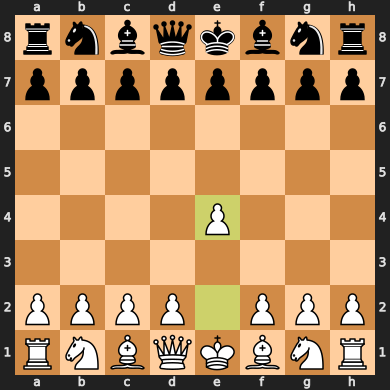

End display strategy attributes.
------------
Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('b1c3'), Move.from_uci('f1c4'), Move.from_uci('f2f4')]

advantages: attack, defence, normalized fut, normal relative


{0: 0.14937759336099585,
 1: 0.32608695652173914,
 2: 0.6285602953240361,
 3: 0.6935059474979491,
 4: 0.7549336795778552,
 5: 0.8688491969258668}

{0: -0.14937759336099585,
 1: 0.1790174544470504,
 2: 0.5578556287209093,
 3: 0.620995324433219,
 4: 0.7022642397064891}

{Move.from_uci('b1c3'): {0: -0.13897596067111673,
  1: 0.18941908713692945,
  2: 0.5682572614107885,
  3: 0.6313969571230982,
  4: 0.7126658723963682},
 Move.from_uci('f1c4'): {0: -0.015560165975103733,
  1: -0.013013956997359485,
  2: 0.04303557208121524,
  3: 0.04303557208121524,
  4: 0.04303557208121524},
 Move.from_uci('f2f4'): {0: 0.002074688796680498,
  1: 0.005186721991701245,
  2: 0.0008850794096379351,
  3: 0.005048502284988063,
  4: 0.005048502284988063}}

{Move.from_uci('b1c3'): {0: 0.32839504780804624,
  1: 0.37883817427385896,
  2: 0.06313969571230969,
  3: 0.0812689152732701},
 Move.from_uci('f1c4'): {0: 0.0025462089777442483,
  1: 0.056049529078574724,
  2: 0.0,
  3: 0.0},
 Move.from_uci('f2f4'): {0: 0.0031120331950207467,
  1: -0.0043016425820633095,
  2: 0.004163422875350128,
  3: 0.0}}

strategies: attack, defence, basic encoded


{0: None,
 1: Move.from_uci('f1c4'),
 2: Move.from_uci('b1c3'),
 3: Move.from_uci('b1c3'),
 4: Move.from_uci('b1c3'),
 5: Move.from_uci('b1c3')}

{0: {},
 1: {Move.from_uci('b1c3'): 4,
  Move.from_uci('f1c4'): 0,
  Move.from_uci('f2f4'): 0},
 2: {Move.from_uci('b1c3'): 4,
  Move.from_uci('f1c4'): 0,
  Move.from_uci('f2f4'): 0},
 3: {Move.from_uci('b1c3'): 4,
  Move.from_uci('f1c4'): 0,
  Move.from_uci('f2f4'): 0},
 4: {Move.from_uci('b1c3'): 4,
  Move.from_uci('f1c4'): 0,
  Move.from_uci('f2f4'): 0}}

[Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1c3')]

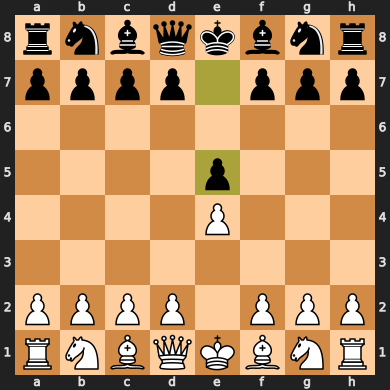

End display strategy attributes.
------------
Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('b8c6'),
 Move.from_uci('f8c5'),
 Move.from_uci('c7c6'),
 Move.from_uci('f8b4'),
 Move.from_uci('g7g6'),
 Move.from_uci('f8e7'),
 Move.from_uci('d7d6'),
 Move.from_uci('c7c5'),
 Move.from_uci('f7f5'),
 Move.from_uci('a7a6'),
 Move.from_uci('b7b6'),
 Move.from_uci('g8e7'),
 Move.from_uci('d7d5')]

advantages: attack, defence, normalized fut, normal relative


{0: -0.14673913043478262,
 1: 0.2,
 2: 0.6000000000000001,
 3: 0.6666666666666666,
 4: 0.7524752475247525}

{0: 0.14673913043478262,
 1: 0.6285602953240361,
 2: 0.6935059474979491,
 3: 0.7549336795778552,
 4: 0.8688491969258668,
 5: 0.9076363822805579}

{Move.from_uci('b8c6'): {0: 0.06383100902378999,
  1: 0.5456521739130434,
  2: 0.5456521739130434,
  3: 0.5456521739130434},
 Move.from_uci('f8c5'): {0: 0.03152173913043478,
  1: 0.09294947121034078,
  2: 0.20686498855835242,
  3: 0.24565217391304348},
 Move.from_uci('c7c6'): {0: 0.008695652173913044,
  1: 0.012228260869565216,
  2: 0.01669254658385093,
  3: 0.01669254658385093},
 Move.from_uci('f8b4'): {0: 0.011956521739130435,
  1: 0.03369565217391304,
  2: 0.03369565217391304,
  3: 0.03369565217391304},
 Move.from_uci('g7g6'): {0: 0.004347826086956522,
  1: 0.010869565217391304,
  2: 0.010869565217391304,
  3: 0.010869565217391304},
 Move.from_uci('f8e7'): {0: -0.0010869565217391304,
  1: 0.0,
  2: 0.0007763975155279503,
  3: 0.0007763975155279503},
 Move.from_uci('d7d6'): {0: 0.017391304347826087,
  1: 0.08233695652173914,
  2: 0.08233695652173914,
  3: 0.08233695652173914},
 Move.from_uci('c7c5'): {0: 0.0021739130434782605,
  1: 0.006521739130434782,
  2: 0.006521739130434782,
  3

{Move.from_uci('b8c6'): {0: 0.4818211648892535, 1: 0.0, 2: 0.0},
 Move.from_uci('f8c5'): {0: 0.061427732079906004,
  1: 0.11391551734801164,
  2: 0.038787185354691056},
 Move.from_uci('c7c6'): {0: 0.003532608695652174,
  1: 0.004464285714285713,
  2: 0.0},
 Move.from_uci('f8b4'): {0: 0.021739130434782608, 1: 0.0, 2: 0.0},
 Move.from_uci('g7g6'): {0: 0.006521739130434782, 1: 0.0, 2: 0.0},
 Move.from_uci('f8e7'): {0: 0.0010869565217391304,
  1: 0.0007763975155279503,
  2: 0.0},
 Move.from_uci('d7d6'): {0: 0.06494565217391304, 1: 0.0, 2: 0.0},
 Move.from_uci('c7c5'): {0: 0.004347826086956522, 1: 0.0, 2: 0.0},
 Move.from_uci('f7f5'): {0: 0.002173913043478261,
  1: 0.006521739130434784,
  2: 0.0},
 Move.from_uci('a7a6'): {0: 0.002173913043478261,
  1: 0.0,
  2: 0.003260869565217391},
 Move.from_uci('b7b6'): {0: 0.005434782608695652, 1: 0.0, 2: 0.0},
 Move.from_uci('g8e7'): {0: 0.0010869565217391304, 1: 0.0, 2: 0.0},
 Move.from_uci('d7d5'): {0: 0.0, 1: 0.0, 2: 0.0}}

strategies: attack, defence, basic encoded


{0: None,
 1: Move.from_uci('f8e7'),
 2: Move.from_uci('f8e7'),
 3: Move.from_uci('c7c5'),
 4: Move.from_uci('d7d6')}

{0: {},
 1: {Move.from_uci('b8c6'): 1,
  Move.from_uci('f8c5'): 3,
  Move.from_uci('c7c6'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('g7g6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('c7c5'): 0,
  Move.from_uci('f7f5'): 0,
  Move.from_uci('a7a6'): 0,
  Move.from_uci('b7b6'): 0,
  Move.from_uci('g8e7'): 0,
  Move.from_uci('d7d5'): 0},
 2: {Move.from_uci('b8c6'): 1,
  Move.from_uci('f8c5'): 3,
  Move.from_uci('c7c6'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('g7g6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('c7c5'): 0,
  Move.from_uci('f7f5'): 0,
  Move.from_uci('a7a6'): 0,
  Move.from_uci('b7b6'): 0,
  Move.from_uci('g8e7'): 0,
  Move.from_uci('d7d5'): 0},
 3: {Move.from_uci('b8c6'): 1,
  Move.from_uci('f8c5'): 3,
  Move.from_uci('c7c6'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('g7g6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('c7c5'): 0,
  Move.from_uci('f7f5'): 0,
 

[Move.from_uci('b8c6'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('d7d6'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8c5'),
 Move.from_uci('b8c6'),
 Move.from_uci('

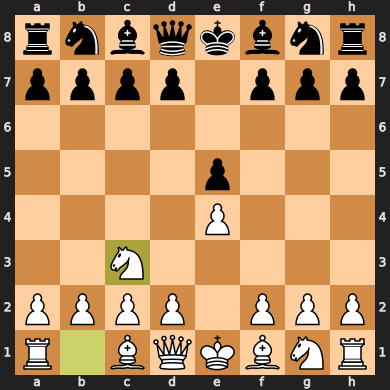

End display strategy attributes.
------------
Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('f2f4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1e2'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('a2a3'),
 Move.from_uci('g1e2'),
 Move.from_uci('f1b5'),
 Move.from_uci('b2b3'),
 Move.from_uci('f1d3')]

advantages: attack, defence, normalized fut, normal relative


{0: 0.1169811320754717, 1: 1.0, 2: 1.0, 3: 1.0}

{0: -0.1169811320754717,
 1: 0.18970637490231104,
 2: 0.28533102230405366,
 3: 0.7351503719628252,
 4: 0.7766598059250893,
 5: 0.8379805606420705,
 6: 0.8643956549816931,
 7: 0.8879805606420705}

{Move.from_uci('f2f4'): {0: -0.04468125117532752,
  1: 0.0509433962264151,
  2: 0.5007627458851867,
  3: 0.5007627458851867},
 Move.from_uci('f1c4'): {0: -0.05385731829853746,
  1: 0.2528301886792453,
  2: 0.2528301886792453,
  3: 0.2528301886792453},
 Move.from_uci('f1e2'): {0: -0.0018867924528301887,
  1: -0.0018867924528301887,
  2: 0.0,
  3: 0.0},
 Move.from_uci('g2g3'): {0: -0.03207547169811321,
  1: 0.009433962264150943,
  2: 0.07075471698113207,
  3: 0.09433962264150943},
 Move.from_uci('d2d3'): {0: -0.003773584905660377,
  1: 0.022641509433962263,
  2: 0.022641509433962263,
  3: 0.022641509433962263},
 Move.from_uci('a2a3'): {0: -0.0037735849056603774,
  1: -0.0037735849056603774,
  2: -0.0037735849056603774,
  3: -0.0037735849056603774},
 Move.from_uci('g1e2'): {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0},
 Move.from_uci('f1b5'): {0: 0.011320754716981131,
  1: 0.011320754716981131,
  2: 0.011320754716981131,
  3: 0.011320754716981131},
 Move.from_uci('b2b3'): {0: 0.0018867924528301887,
  

{Move.from_uci('f2f4'): {0: 0.09562464740174262,
  1: 0.4498193496587715,
  2: 0.0},
 Move.from_uci('f1c4'): {0: 0.30668750697778274, 1: 0.0, 2: 0.0},
 Move.from_uci('f1e2'): {0: 0.0, 1: 0.0018867924528301887, 2: 0.0},
 Move.from_uci('g2g3'): {0: 0.04150943396226415,
  1: 0.06132075471698113,
  2: 0.023584905660377353},
 Move.from_uci('d2d3'): {0: 0.026415094339622643, 1: 0.0, 2: 0.0},
 Move.from_uci('a2a3'): {0: 0.0, 1: 0.0, 2: 0.0},
 Move.from_uci('g1e2'): {0: 0.0, 1: 0.0, 2: 0.0},
 Move.from_uci('f1b5'): {0: 0.0, 1: 0.0, 2: 0.0},
 Move.from_uci('b2b3'): {0: 0.0, 1: 0.0, 2: 0.0},
 Move.from_uci('f1d3'): {0: 0.0, 1: 0.0, 2: 0.0}}

strategies: attack, defence, basic encoded


{0: None,
 1: Move.from_uci('f1e2'),
 2: Move.from_uci('a2a3'),
 3: Move.from_uci('a2a3')}

{0: {},
 1: {Move.from_uci('f2f4'): 2,
  Move.from_uci('f1c4'): 1,
  Move.from_uci('f1e2'): 0,
  Move.from_uci('g2g3'): 3,
  Move.from_uci('d2d3'): 1,
  Move.from_uci('a2a3'): 0,
  Move.from_uci('g1e2'): 0,
  Move.from_uci('f1b5'): 0,
  Move.from_uci('b2b3'): 0,
  Move.from_uci('f1d3'): 0},
 2: {Move.from_uci('f2f4'): 2,
  Move.from_uci('f1c4'): 1,
  Move.from_uci('f1e2'): 0,
  Move.from_uci('g2g3'): 3,
  Move.from_uci('d2d3'): 1,
  Move.from_uci('a2a3'): 0,
  Move.from_uci('g1e2'): 0,
  Move.from_uci('f1b5'): 0,
  Move.from_uci('b2b3'): 0,
  Move.from_uci('f1d3'): 0},
 3: {Move.from_uci('f2f4'): 2,
  Move.from_uci('f1c4'): 1,
  Move.from_uci('f1e2'): 0,
  Move.from_uci('g2g3'): 3,
  Move.from_uci('d2d3'): 1,
  Move.from_uci('a2a3'): 0,
  Move.from_uci('g1e2'): 0,
  Move.from_uci('f1b5'): 0,
  Move.from_uci('b2b3'): 0,
  Move.from_uci('f1d3'): 0},
 4: {Move.from_uci('f2f4'): 2,
  Move.from_uci('f1c4'): 1,
  Move.from_uci('f1e2'): 0,
  Move.from_uci('g2g3'): 3,
  Move.from_uci('d2d3'): 

[Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('f2f4'),
 Move.from_uci('

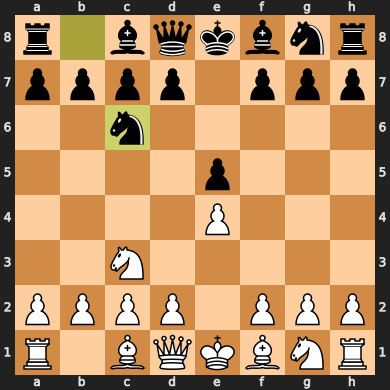

End display strategy attributes.
------------
Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('e5f4'),
 Move.from_uci('f8c5'),
 Move.from_uci('f8b4'),
 Move.from_uci('d7d6'),
 Move.from_uci('g8f6'),
 Move.from_uci('a7a6'),
 Move.from_uci('f8e7'),
 Move.from_uci('f8d6'),
 Move.from_uci('f7f6')]

advantages: attack, defence, normalized fut, normal relative


{0: -0.07973421926910298,
 1: 0.09090909090909091,
 2: 0.8936170212765957,
 3: 0.8936170212765957}

{0: 0.07973421926910298,
 1: 0.18237082066869303,
 2: 0.2472710070875019,
 3: 0.36929620907692573}

{Move.from_uci('e5f4'): {0: 0.013163074113145755,
  1: 0.07806326053195463,
  2: 0.20008846252137846},
 Move.from_uci('f8c5'): {0: -0.0033222591362126247,
  1: 0.025628856193640248,
  2: 0.0320360702420503},
 Move.from_uci('f8b4'): {0: -0.003322259136212625,
  1: 0.005220692928334125,
  2: 0.02610346464167062},
 Move.from_uci('d7d6'): {0: 0.04354280059376547,
  1: 0.1461794019933555,
  2: 0.1461794019933555},
 Move.from_uci('g8f6'): {0: 0.009966777408637873,
  1: 0.013289036544850499,
  2: 0.013289036544850499},
 Move.from_uci('a7a6'): {0: 0.0033222591362126247,
  1: 0.0033222591362126247,
  2: 0.0033222591362126247},
 Move.from_uci('f8e7'): {0: 0.006644518272425249,
  1: 0.006644518272425249,
  2: 0.008305647840531562},
 Move.from_uci('f8d6'): {0: 0.0033222591362126247,
  1: 0.0033222591362126247,
  2: 0.0033222591362126247},
 Move.from_uci('f7f6'): {0: 0.006644518272425249,
  1: 0.006644518272425249,
  2: 0.006644518272425249}}

{Move.from_uci('e5f4'): {0: 0.06490018641880888, 1: 0.12202520198942383},
 Move.from_uci('f8c5'): {0: 0.02895111532985287, 1: 0.006407214048410059},
 Move.from_uci('f8b4'): {0: 0.00854295206454675, 1: 0.0208827717133365},
 Move.from_uci('d7d6'): {0: 0.10263660139959004, 1: 0.0},
 Move.from_uci('g8f6'): {0: 0.0033222591362126247, 1: 0.0},
 Move.from_uci('a7a6'): {0: 0.0, 1: 0.0},
 Move.from_uci('f8e7'): {0: 0.0, 1: 0.0016611295681063123},
 Move.from_uci('f8d6'): {0: 0.0, 1: 0.0},
 Move.from_uci('f7f6'): {0: 0.0, 1: 0.0}}

strategies: attack, defence, basic encoded


{0: None,
 1: Move.from_uci('f8b4'),
 2: Move.from_uci('d7d6'),
 3: Move.from_uci('d7d6')}

{0: {},
 1: {Move.from_uci('e5f4'): 2,
  Move.from_uci('f8c5'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('g8f6'): 0,
  Move.from_uci('a7a6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('f8d6'): 0,
  Move.from_uci('f7f6'): 0},
 2: {Move.from_uci('e5f4'): 2,
  Move.from_uci('f8c5'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('g8f6'): 0,
  Move.from_uci('a7a6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('f8d6'): 0,
  Move.from_uci('f7f6'): 0},
 3: {Move.from_uci('e5f4'): 2,
  Move.from_uci('f8c5'): 0,
  Move.from_uci('f8b4'): 0,
  Move.from_uci('d7d6'): 1,
  Move.from_uci('g8f6'): 0,
  Move.from_uci('a7a6'): 0,
  Move.from_uci('f8e7'): 0,
  Move.from_uci('f8d6'): 0,
  Move.from_uci('f7f6'): 0}}

[Move.from_uci('d7d6'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4'),
 Move.from_uci('d7d6'),
 Move.from_uci('e5f4'),
 Move.from_uci('e5f4')]

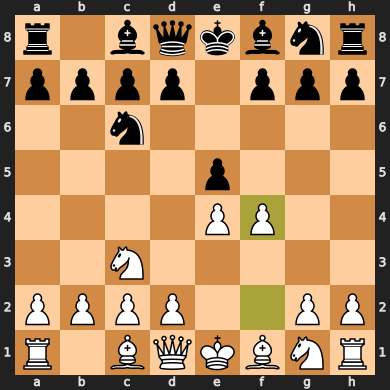

End display strategy attributes.
------------
Displaying strategy attributes
available_moves: all but  0


[Move.from_uci('f1c4'), Move.from_uci('d2d4')]

advantages: attack, defence, normalized fut, normal relative


{0: 1.0, 1: 1.0}

{0: -1.0, 1: -1.0}

{Move.from_uci('f1c4'): {0: -0.5, 1: -0.5},
 Move.from_uci('d2d4'): {0: -0.5, 1: -0.5}}

{Move.from_uci('f1c4'): {0: 0.0}, Move.from_uci('d2d4'): {0: 0.0}}

strategies: attack, defence, basic encoded


{0: None, 1: Move.from_uci('f1c4')}

{0: {}, 1: {Move.from_uci('f1c4'): 1, Move.from_uci('d2d4'): 0}}

[Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1c4')]

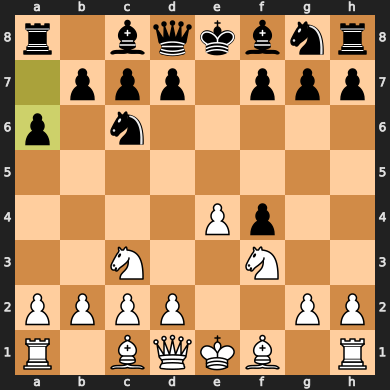

End display strategy attributes.
------------


In [309]:
def display_strategy_attributes(pos):
    print("Displaying strategy attributes")
    print("available_moves: all but ", len(pos.moves)-len(pos.available_moves))
    display(pos.available_moves)
    print("advantages: attack, defence, normalized fut, normal relative")
    display(pos.attack_advantage)
    display(pos.defence_advantage)
    display(pos.normalized_future_advantages)
    display(pos.normalized_relative_advantages)
    print("strategies: attack, defence, basic encoded")
    display(pos.attack_strategy)    
    display(pos.defence_strategy)
    display(pos.basic_strategy_encoded)
    display(pos.board)
    
    print("End display strategy attributes.")
    print("------------")
    
for pos in few_games.values():
    display_strategy_attributes(pos)

### MVP1, part 2: analyze the benefit of a white move

In [195]:
# given a position, for every variation 
# calculate the advantage of the next position
def calculate_advantages(position,dictionary):
    answer = {}
    
    for move, variation_id in position.variations_available.items():
        if variation_id not in dictionary.keys():
            continue
            
        variation_position  = dictionary[variation_id]
        
        variation_advantage = variation_position.white_advantage
        
        answer[move] = variation_advantage
    
    return answer
    
# given the previous function, find the best move
# calculating the maximal advantage
def find_best_move(dictionary_advantages):
    max_advantage = -2   # any number less than -1 would do
    best_move = None
    
    for move, variation_adv in dictionary_advantages.items():     
        if variation_adv > max_advantage:
            best_move = move
            max_advantage = variation_adv
    
    return {"move": best_move, "advantage": max_advantage}

In [196]:
# for every white position in dizionario we can run an analyzer
class AnalysisWhitePosition:
    def __init__(self,dizionario,position_id,num_games): 
        pos = dizionario[position_id]
        
        self.id = position_id
        self.board = pos.board
        self.frequency = float(pos.multiplicity) / float(num_games)
        
        self.wa = {}
        self.wa[0] = pos.white_advantage
        
        one_move_advantages = calculate_advantages(pos,dizionario)
        best = find_best_move(one_move_advantages)
        
        self.best_move = best["move"]
        self.wa[1] = best["advantage"]
        self.one_move_advantage = (best["advantage"]- pos.white_advantage) * self.frequency
        
    def display_analysis(self):
        print("The best move for the position")
        print(self.id)
        display(self.board)
        print("is")
        display(self.best_move)
        print("it gives a study advantage of")
        print(self.one_move_advantage)
 

In [197]:
# I look only at the positions where white plays
dictionary_white = {k:v for (k,v) in dizionario.items() if v.turn == chess.WHITE}

In [13]:
# analyze all positions where white plays
analysis_white = {k:AnalysisWhitePosition(dizionario,k,num_games) for k in dictionary_white}
study_advantages_white = {k:v.one_move_advantage for (k,v) in analysis_white.items()}

The best move for the position
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - FEN_id 


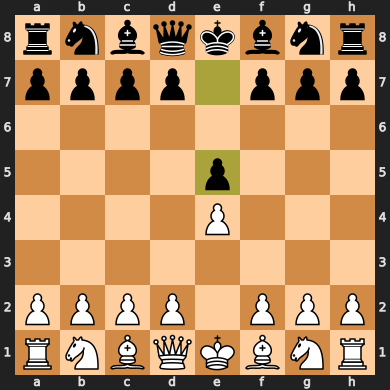

is


Move.from_uci('f1c4')

it gives a study advantage of
0.17034782608695653


In [14]:
# the move that grants the best advantage if studied
best_of_the_best_id = max(study_advantages_white,key=study_advantages_white.get)

analysis_white[best_of_the_best_id].display_analysis()

## MVP2

The objective of MVP2 is to learn to respond to the game of black (the opponent). 

Given a position where black plays, there are several variants that could be taken into account. 

For each of these variants, we can calculate 
1. The frequency of the variant
2. The best answer of white
3. The relative advantage that white gains from playing the best answer (as compared to playing randomly)
4. The realistic advantage that takes into account the frequency of the variant

The idea is: should we learn white hidden killer moves that answer to a very rare move of black, or rather should we learn to get slight tactical advantages to very common moves? The relative quantities have to be carefully examinated. Ideally, we would like to learn hidden killer answer to very common opponent moves.

Todos at the top of this document




In [15]:
# I look only at the positions where white plays
dictionary_black = {k:v for (k,v) in dizionario.items() if v.turn == chess.BLACK}

In [ ]:
# for every white position in dizionario we can run an analyzer
class AnalysisBlackPosition:
    def __init__(self,dizionario,position_id): 
        pos = dizionario[position_id]
        
        self.id = position_id
        self.board = pos.board
        
        self.wa = {}
        self.wa[0] = pos.white_advantage
        
        one_move_advantages = calculate_advantages(pos,dizionario)
        best = find_best_move(one_move_advantages)
        
        self.best_move = best["move"]
        self.wa[1] = best["advantage"]
        self.one_move_advantage = (best["advantage"]- pos.white_advantage) * self.frequency
        
    def display_analysis(self):
        print("The best move for the position")
        print(self.id)
        display(self.board)
        print("is")
        display(self.best_move)
        print("it gives a study advantage of")
        print(self.one_move_advantage)

## Debug

In [34]:
aw = analysis_white[best_of_the_best_id]

## Tests


In [58]:
test_game = chess.pgn.read_game(pgn)

In [59]:
test_class = MyGame(test_game)

In [66]:
print(test_class.id)
print(test_class.board)
print(test_class.multiplicity)
test_class.update(test_game)
display(test_class.moves_available)
display(test_class.variations_available)

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - FEN_id 
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
3


[Move.from_uci('e2e4')]

{Move.from_uci('e2e4'): 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - FEN_id '}

In [67]:
re.sub('[0-9]+ [0-9]+$','FEN_id ',test_class.board.fen())

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - FEN_id '

In [68]:
b= test_game.board()

In [69]:
f= b.fen()

In [70]:
b.board_fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'

In [71]:
b.turn

True

In [72]:
b.fullmove_number

1

In [73]:
b.halfmove_clock

0

In [74]:
b.halfmove_clock=5

In [75]:
b.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 5 1'

In [76]:
f

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

Pyhton regex replace
https://appdividend.com/2022/01/27/python-regex-replace/#:~:text=1%20Python%20regex%20replace.%20To%20replace%20a%20string,Python%20using%20regular%20expressions.%20...%208%20See%20also
import re
re.sub

regex number /[0-100]/ will suffice for me
regex endline /$/


In [77]:
import re
print(re.sub('[0-9]+ [0-9]+$','FEN_id ',f))

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - FEN_id 


### Test transcribing into a dictionary the first few moves



In [78]:
def parse_game(dizionario,new_game):

    new_position = new_game

    for move in new_game.mainline_moves():  
        
        new_position = new_position.variation(move)
        
        new_id = gamenode_to_id(new_position)

        if new_id in dizionario.keys():
            dizionario[new_id].update(new_position)
        else:
            dizionario[new_id] = MyGame(new_position)

        if new_position.ply() == 4:
            break
            
            #rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - FEN_id
            #rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - FEN_id 

In [79]:
dizionario = {}
pgn = open_test_pgn()

#8 sec for 1000 games depth 4
for i in range(1000):
    game = chess.pgn.read_game(pgn)
    parse_game(dizionario,game)

In [80]:
dizionario.keys()

dict_keys(['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - FEN_id ', 'rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - FEN_id ', 'rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR b KQkq - FEN_id ', 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqkbnr/pp1p1ppp/2p5/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'r1bqkbnr/pppppppp/2n5/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - FEN_id ', 'r1bqkbnr/pppppppp/2n5/8/4P3/2N5/PPPP1PPP/R1BQKBNR b KQkq - FEN_id ', 'rnbqkbnr/pppp1p1p/6p1/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - FEN_id ', 'rnbqkbnr/pppp1ppp/8/4p3/8/2N5/PPPPPPPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqk1nr/ppppbppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqkbnr/ppp2ppp/3p4/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ', 'rnbqkbnr/pp

In [88]:
def calculate_advantages(position,dictionary):
    answer = {}
    
    for move, variation_id in position.variations_available.items():
        if variation_id not in dictionary.keys():
            continue
            
        variation_position  = dictionary[variation_id]
        
        variation_advantage = variation_position.white_advantage
        
        answer[move] = variation_advantage
    
    return answer
    
    
def find_best_move(dictionary_advantages):
    max_advantage = -2   # any number less than -1 would do
    best_move = None
    
    for move, variation_adv in dictionary_advantages.items():     
        if variation_adv > max_advantage:
            best_move = move
            max_advantage = variation_adv
    
    return {"move": best_move, "advantage": max_advantage}

This position has been found 990 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
34.13793103448276
It has a white advantage equal to
0.1484848484848485
Its results are
[468-201-321]
:


{Move.from_uci('e7e5'): 'rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - FEN_id ',
 Move.from_uci('b8c6'): 'r1bqkbnr/pppppppp/2n5/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - FEN_id '}

[Move.from_uci('e7e5'), Move.from_uci('b8c6')]

{Move.from_uci('e7e5'): 0.14937759336099585,
 Move.from_uci('b8c6'): 0.11538461538461539}

Best move


Move.from_uci('e7e5')

with an advantage equal to 
0.14937759336099585
and a relative advantage equal to
0.00089274487614735
since  it has a white advantage equal to
0.1484848484848485
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
0.030476463013306088
:


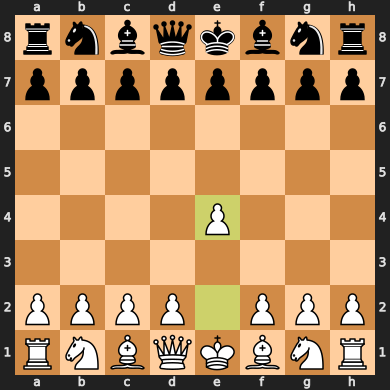

This position has been found 964 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
33.241379310344826
It has a white advantage equal to
0.14937759336099585
Its results are
[456-196-312]
:


{Move.from_uci('b1c3'): 'rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('f1c4'): 'rnbqkbnr/pppp1ppp/8/4p3/2B1P3/8/PPPP1PPP/RNBQK1NR b KQkq - FEN_id ',
 Move.from_uci('f2f4'): 'rnbqkbnr/pppp1ppp/8/4p3/4PP2/8/PPPP2PP/RNBQKBNR b KQkq - FEN_id '}

[Move.from_uci('b1c3'), Move.from_uci('f1c4'), Move.from_uci('f2f4')]

{Move.from_uci('b1c3'): 0.14673913043478262,
 Move.from_uci('f1c4'): 0.32608695652173914,
 Move.from_uci('f2f4'): -0.4}

Best move


Move.from_uci('f1c4')

with an advantage equal to 
0.32608695652173914
and a relative advantage equal to
0.1767093631607433
since  it has a white advantage equal to
0.14937759336099585
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
5.874062968515742
:


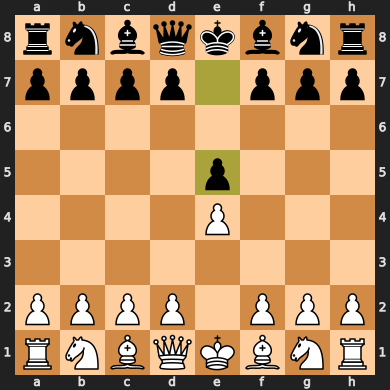

This position has been found 920 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
31.724137931034484
It has a white advantage equal to
0.14673913043478262
Its results are
[438-179-303]
:


{Move.from_uci('b8c6'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('f8c5'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('c7c6'): 'rnbqkbnr/pp1p1ppp/2p5/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('f8b4'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('g7g6'): 'rnbqkbnr/pppp1p1p/6p1/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('f8e7'): 'rnbqk1nr/ppppbppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('d7d6'): 'rnbqkbnr/ppp2ppp/3p4/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('c7c5'): 'rnbqkbnr/pp1p1ppp/8/2p1p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('f7f5'): 'rnbqkbnr/pppp2pp/8/4pp2/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('a7a6'): 'rnbqkbnr/1ppp1ppp/p7/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR w KQkq - FEN_id ',
 Move.from_uci('b7b6'): 'rnbqkbnr/p1pp1ppp/1p6

[Move.from_uci('b8c6'),
 Move.from_uci('f8c5'),
 Move.from_uci('c7c6'),
 Move.from_uci('f8b4'),
 Move.from_uci('g7g6'),
 Move.from_uci('f8e7'),
 Move.from_uci('d7d6'),
 Move.from_uci('c7c5'),
 Move.from_uci('f7f5'),
 Move.from_uci('a7a6'),
 Move.from_uci('b7b6'),
 Move.from_uci('g8e7'),
 Move.from_uci('d7d5')]

{Move.from_uci('b8c6'): 0.1169811320754717,
 Move.from_uci('f8c5'): 0.12831858407079647,
 Move.from_uci('c7c6'): 0.5333333333333333,
 Move.from_uci('f8b4'): 0.3548387096774194,
 Move.from_uci('g7g6'): 0.4,
 Move.from_uci('f8e7'): -0.2,
 Move.from_uci('d7d6'): 0.15841584158415842,
 Move.from_uci('c7c5'): 0.3333333333333333,
 Move.from_uci('f7f5'): 0.1111111111111111,
 Move.from_uci('a7a6'): 0.6666666666666666,
 Move.from_uci('b7b6'): 0.16666666666666666,
 Move.from_uci('g8e7'): 0.5,
 Move.from_uci('d7d5'): 1.0}

Best move


Move.from_uci('d7d5')

with an advantage equal to 
1.0
and a relative advantage equal to
0.8532608695652174
since  it has a white advantage equal to
0.14673913043478262
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
27.06896551724138
:


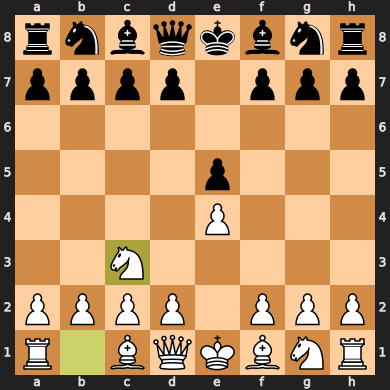

This position has been found 530 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
18.275862068965516
It has a white advantage equal to
0.1169811320754717
Its results are
[248-96-186]
:


{Move.from_uci('f2f4'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4PP2/2N5/PPPP2PP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('f1c4'): 'r1bqkbnr/pppp1ppp/2n5/4p3/2B1P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('f1e2'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2N5/PPPPBPPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('g2g3'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2N3P1/PPPP1P1P/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('d2d3'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2NP4/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('a2a3'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/P1N5/1PPP1PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('g1e2'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2N5/PPPPNPPP/R1BQKB1R b KQkq - FEN_id ',
 Move.from_uci('f1b5'): 'r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('b2b3'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/1PN5/P1PP1PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('f1d3'): 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/2NB4/PPPP1PPP/R1BQK1NR b KQkq - FEN_id '}

[Move.from_uci('f2f4'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1e2'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('a2a3'),
 Move.from_uci('g1e2'),
 Move.from_uci('f1b5'),
 Move.from_uci('b2b3'),
 Move.from_uci('f1d3')]

{}

Best move


None

with an advantage equal to 
-2
and a relative advantage equal to
-2.116981132075472
since  it has a white advantage equal to
0.1169811320754717
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
-38.689655172413794
:


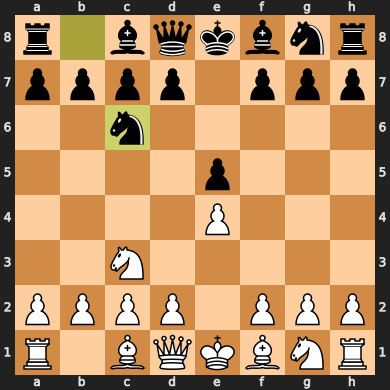

This position has been found 226 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
7.793103448275862
It has a white advantage equal to
0.12831858407079647
Its results are
[98-59-69]
:


{Move.from_uci('c3a4'): 'rnbqk1nr/pppp1ppp/8/2b1p3/N3P3/8/PPPP1PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('g1f3'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2N2N2/PPPP1PPP/R1BQKB1R b KQkq - FEN_id ',
 Move.from_uci('f2f4'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4PP2/2N5/PPPP2PP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('g2g3'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2N3P1/PPPP1P1P/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('f1c4'): 'rnbqk1nr/pppp1ppp/8/2b1p3/2B1P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('d1g4'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P1Q1/2N5/PPPP1PPP/R1B1KBNR b KQkq - FEN_id ',
 Move.from_uci('d2d3'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2NP4/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('d2d4'): 'rnbqk1nr/pppp1ppp/8/2b1p3/3PP3/2N5/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('d1e2'): 'rnbqk1nr/pppp1ppp/8/2b1p3/4P3/2N5/PPPPQPPP/R1B1KBNR b KQkq - FEN_id ',
 Move.from_uci('f1b5'): 'rnbqk1nr/pppp1ppp/8/1Bb1p3/4P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('g1h3'): 'rnbqk1n

[Move.from_uci('c3a4'),
 Move.from_uci('g1f3'),
 Move.from_uci('f2f4'),
 Move.from_uci('g2g3'),
 Move.from_uci('f1c4'),
 Move.from_uci('d1g4'),
 Move.from_uci('d2d3'),
 Move.from_uci('d2d4'),
 Move.from_uci('d1e2'),
 Move.from_uci('f1b5'),
 Move.from_uci('g1h3')]

{}

Best move


None

with an advantage equal to 
-2
and a relative advantage equal to
-2.1283185840707963
since  it has a white advantage equal to
0.12831858407079647
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
-16.586206896551722
:


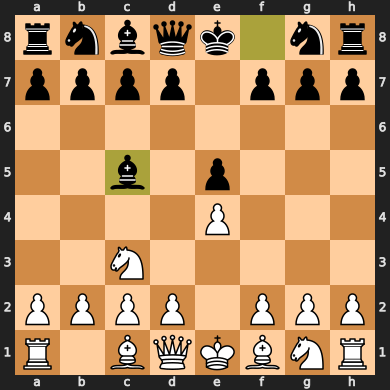

This position has been found 15 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
0.5172413793103449
It has a white advantage equal to
0.5333333333333333
Its results are
[11-1-3]
:


{Move.from_uci('f2f4'): 'rnbqkbnr/pp1p1ppp/2p5/4p3/4PP2/2N5/PPPP2PP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('f1c4'): 'rnbqkbnr/pp1p1ppp/2p5/4p3/2B1P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('d2d4'): 'rnbqkbnr/pp1p1ppp/2p5/4p3/3PP3/2N5/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('g1f3'): 'rnbqkbnr/pp1p1ppp/2p5/4p3/4P3/2N2N2/PPPP1PPP/R1BQKB1R b KQkq - FEN_id '}

[Move.from_uci('f2f4'),
 Move.from_uci('f1c4'),
 Move.from_uci('d2d4'),
 Move.from_uci('g1f3')]

{}

Best move


None

with an advantage equal to 
-2
and a relative advantage equal to
-2.533333333333333
since  it has a white advantage equal to
0.5333333333333333
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
-1.3103448275862069
:


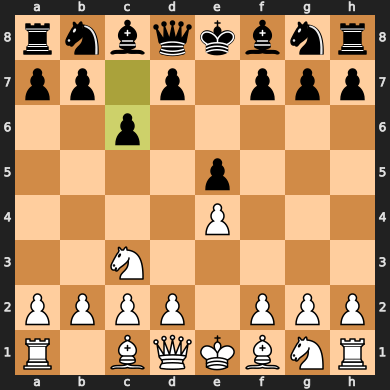

This position has been found 31 times
Since we visited a total of 29 games
we may say that this position has a frequency equal to
1.0689655172413792
It has a white advantage equal to
0.3548387096774194
Its results are
[19-4-8]
:


{Move.from_uci('f1c4'): 'rnbqk1nr/pppp1ppp/8/4p3/1bB1P3/2N5/PPPP1PPP/R1BQK1NR b KQkq - FEN_id ',
 Move.from_uci('d1g4'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P1Q1/2N5/PPPP1PPP/R1B1KBNR b KQkq - FEN_id ',
 Move.from_uci('g1e2'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2N5/PPPPNPPP/R1BQKB1R b KQkq - FEN_id ',
 Move.from_uci('g2g3'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2N3P1/PPPP1P1P/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('c3d5'): 'rnbqk1nr/pppp1ppp/8/3Np3/1b2P3/8/PPPP1PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('d2d4'): 'rnbqk1nr/pppp1ppp/8/4p3/1b1PP3/2N5/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('g1f3'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2N2N2/PPPP1PPP/R1BQKB1R b KQkq - FEN_id ',
 Move.from_uci('d2d3'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/2NP4/PPP2PPP/R1BQKBNR b KQkq - FEN_id ',
 Move.from_uci('a2a3'): 'rnbqk1nr/pppp1ppp/8/4p3/1b2P3/P1N5/1PPP1PPP/R1BQKBNR b KQkq - FEN_id '}

[Move.from_uci('f1c4'),
 Move.from_uci('d1g4'),
 Move.from_uci('g1e2'),
 Move.from_uci('g2g3'),
 Move.from_uci('c3d5'),
 Move.from_uci('d2d4'),
 Move.from_uci('g1f3'),
 Move.from_uci('d2d3'),
 Move.from_uci('a2a3')]

{}

Best move


None

with an advantage equal to 
-2
and a relative advantage equal to
-2.3548387096774195
since  it has a white advantage equal to
0.3548387096774194
Now, given the frequency of the position, 
and the relative advantage that we gain by studying the position,
we deduce that the real advantage we gain from studying this position is
-2.5172413793103448
:


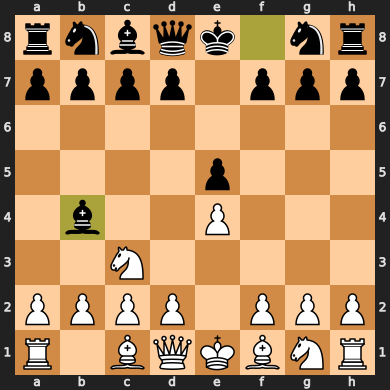

In [91]:
j = 0
num_games = len(dizionario.keys())
for fen, pos in dizionario.items():     
    print("This position has been found %d times"%pos.multiplicity)
    print("Since we visited a total of %d games"%num_games)
    frequency = float(pos.multiplicity) / float(num_games)
    print("we may say that this position has a frequency equal to")
    print(frequency)
    print("It has a white advantage equal to")
    print(pos.white_advantage)
    print("Its results are")
    print("[%d-%d-%d]"%(pos.white_wins,pos.draws,pos.black_wins))
    print(":")
    display(pos.variations_available)
    display(pos.moves_available)
    one_move_advantages = calculate_advantages(pos,dizionario)
    display(one_move_advantages)
    print ("Best move")
    best = find_best_move(one_move_advantages)
    display(best["move"])
    print("with an advantage equal to ")
    print(best["advantage"])
    print("and a relative advantage equal to")
    relative_advantage = best["advantage"]- pos.white_advantage
    print(relative_advantage)
    print("since  it has a white advantage equal to")
    print(pos.white_advantage)
    
    print("Now, given the frequency of the position, ")
    print("and the relative advantage that we gain by studying the position,") 
    print("we deduce that the real advantage we gain from studying this position is")
    real_advantage = relative_advantage * frequency
    print(real_advantage)
    
    
    print(":")
    display(pos.board)
    
    j+=1
    if j==7:
        break

## Game results debug



1-0


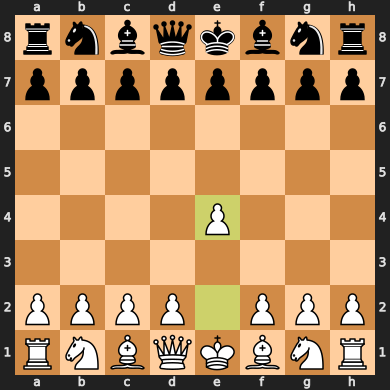

1-0


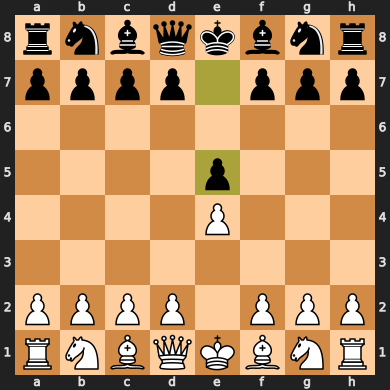

1-0


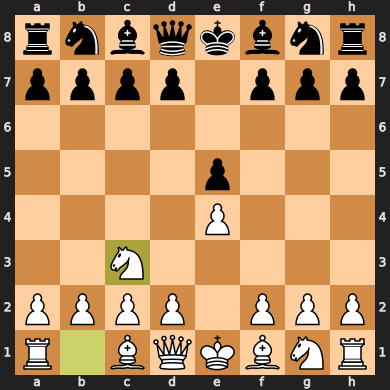

1-0


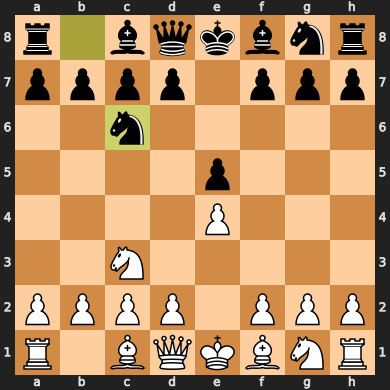

In [24]:
pgn = open_test_pgn()

def results_game(depth):
    new_game = chess.pgn.read_game(pgn)
    
    if new_game == None:
        return

    new_position = new_game

    for move in new_game.mainline_moves():  
        
        new_position = new_position.variation(move)
        
        print(new_position.game().headers['Result'])
        display(new_position.board())

        if new_position.ply() == depth:
            break

results_game(4)

0-1


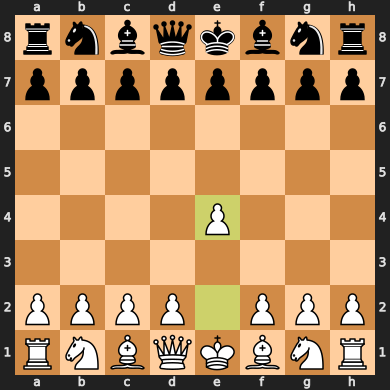

1-0


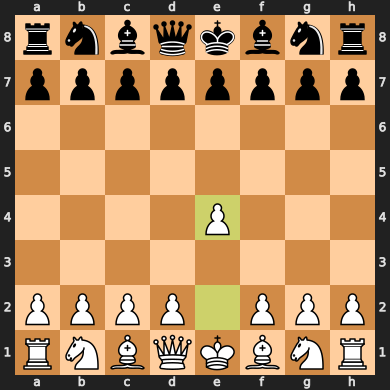

1-0


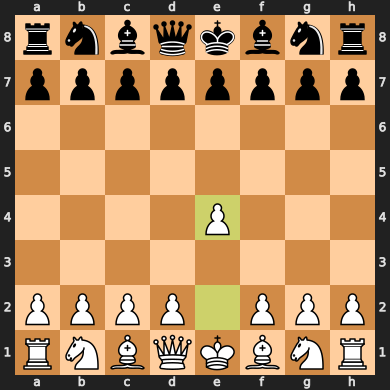

1/2-1/2


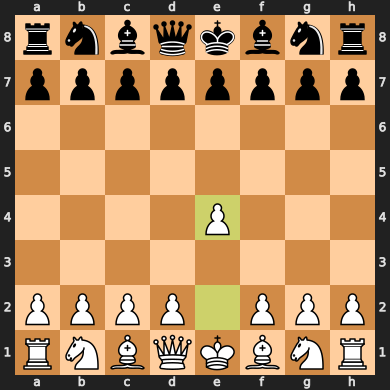

1-0


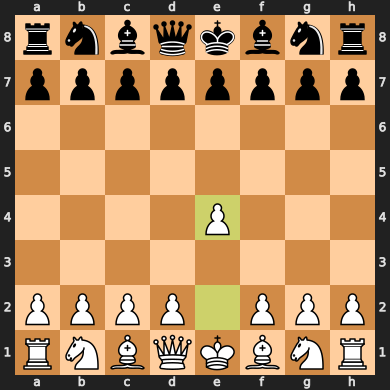

0-1


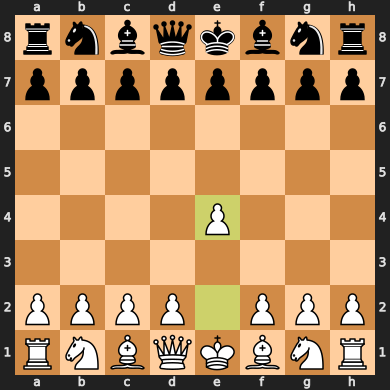

1/2-1/2


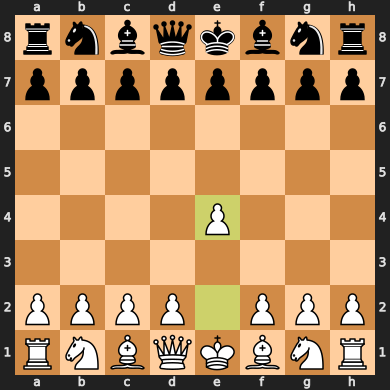

1-0


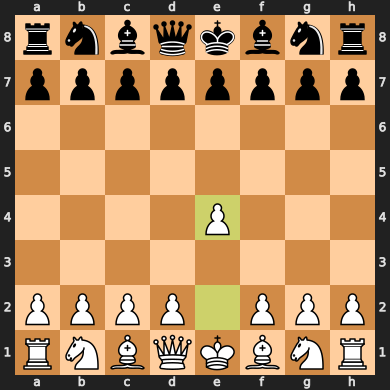

1-0


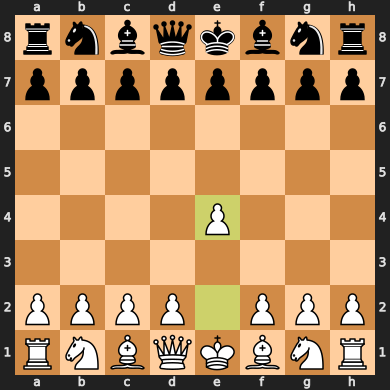

1-0


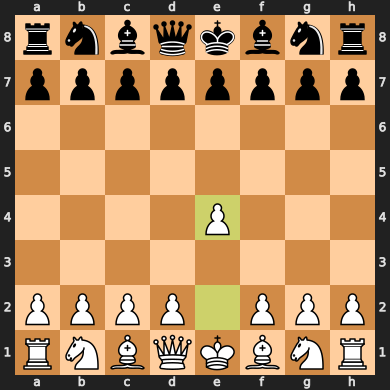

0-1


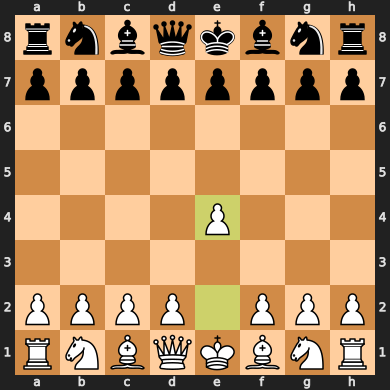

1-0


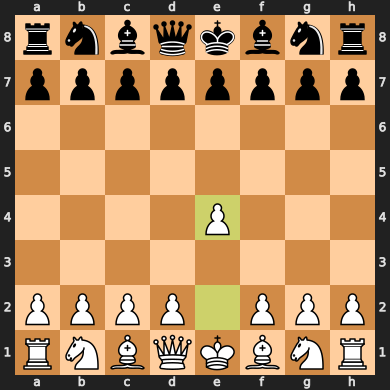

0-1


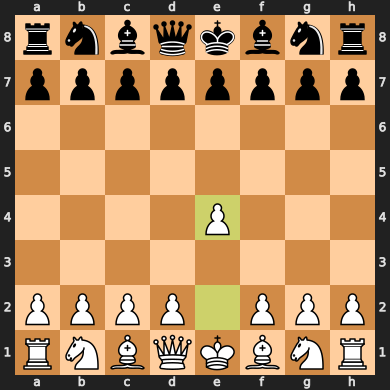

0-1


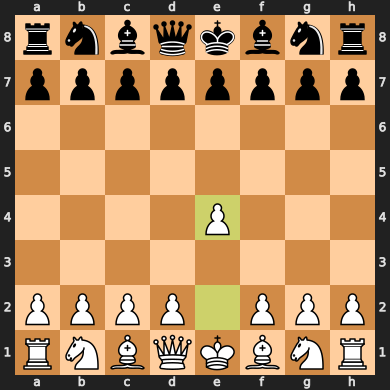

1-0


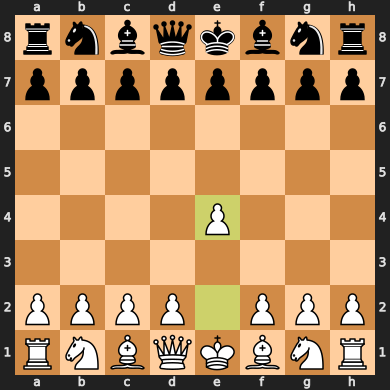

0-1


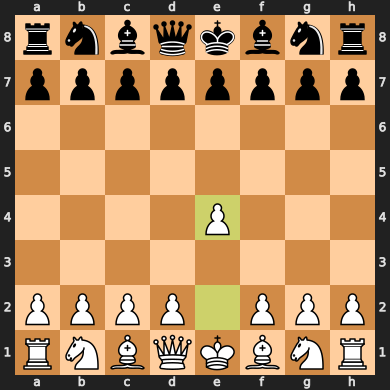

1/2-1/2


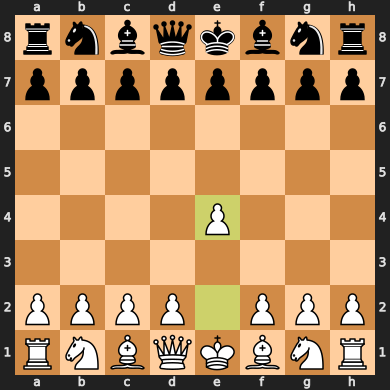

1-0


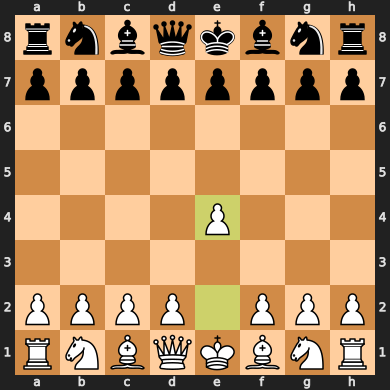

1-0


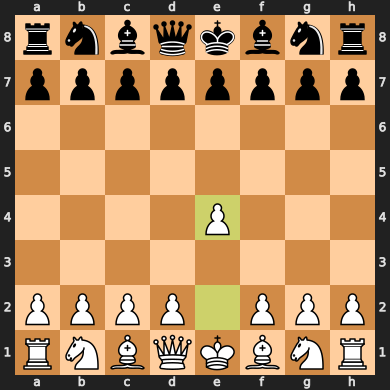

1-0


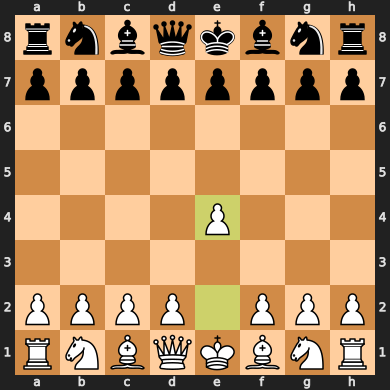

1-0


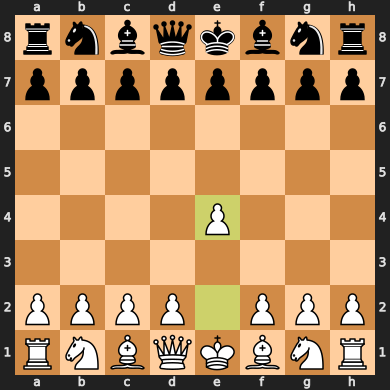

1-0


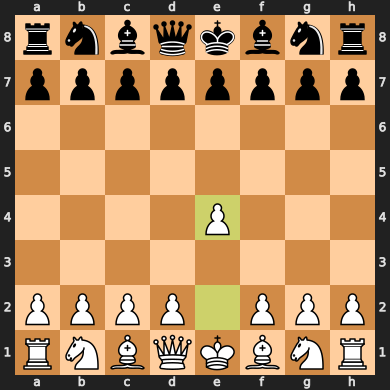

1-0


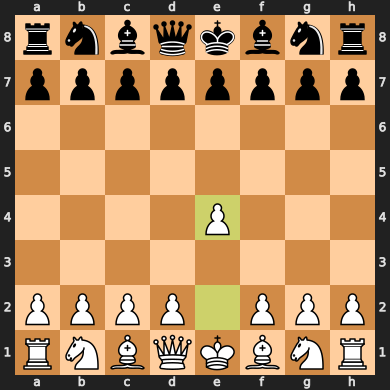

1-0


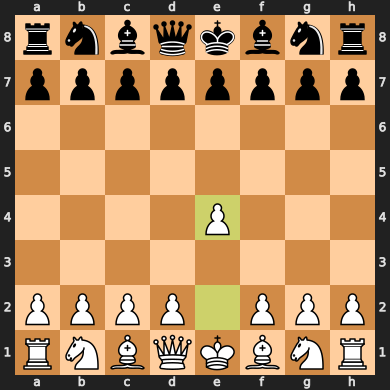

0-1


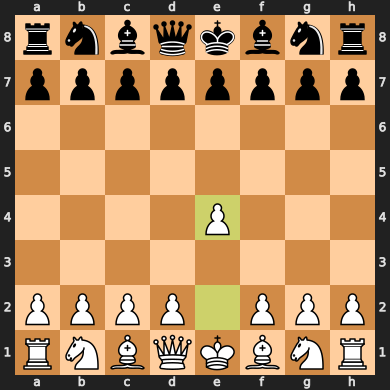

1-0


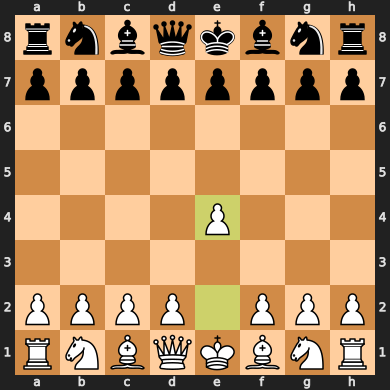

1-0


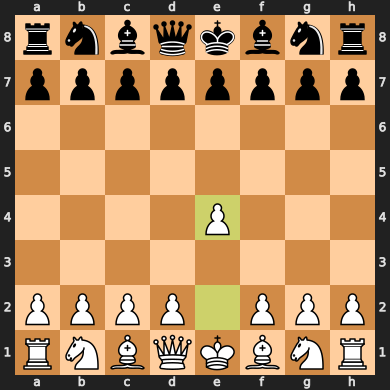

1-0


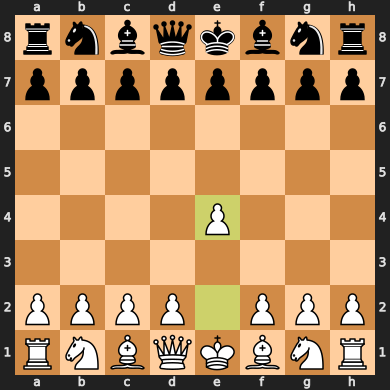

1-0


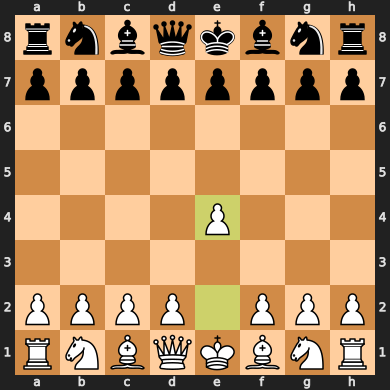

0-1


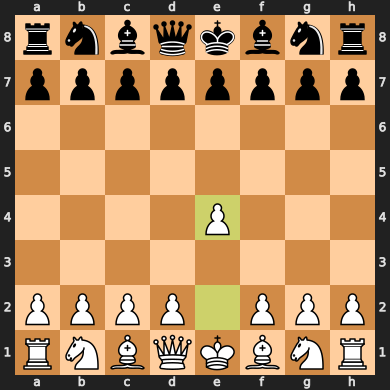

0-1


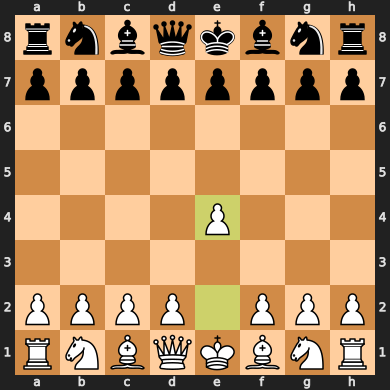

1-0


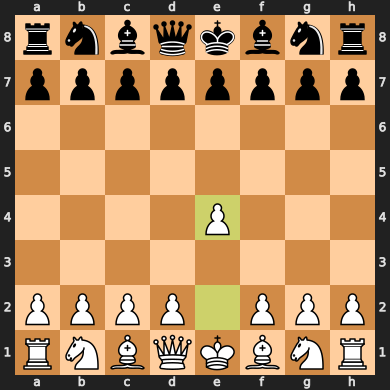

1-0


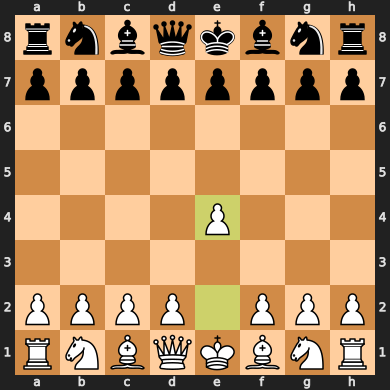

1-0


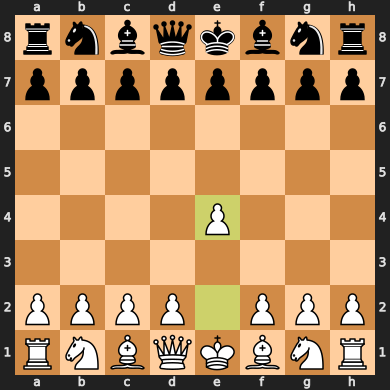

1-0


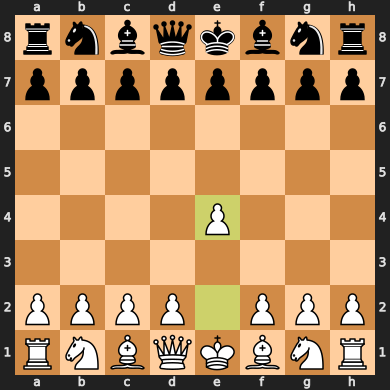

1-0


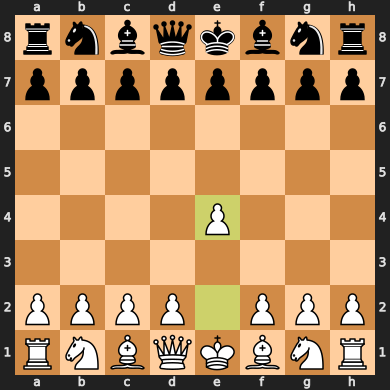

0-1


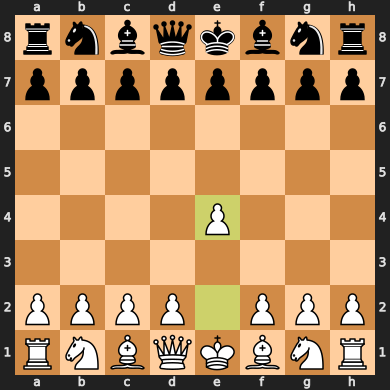

1-0


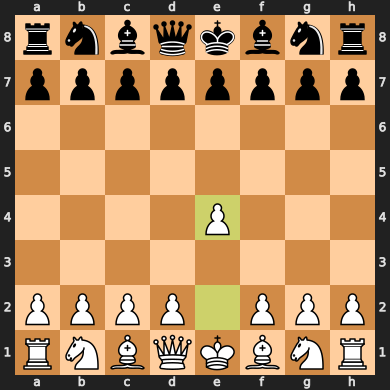

0-1


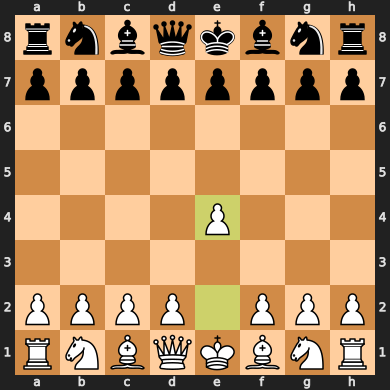

0-1


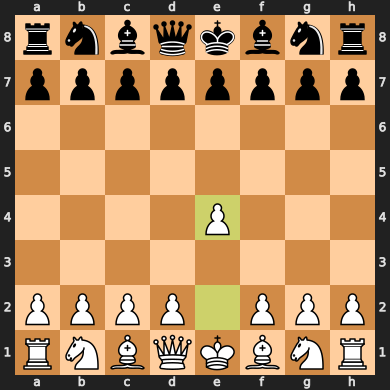

1-0


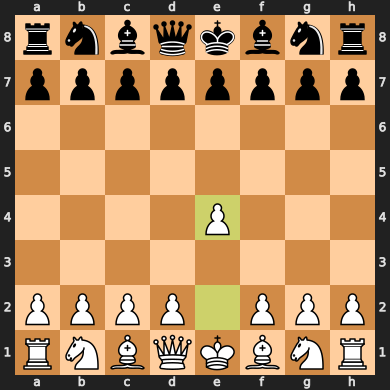

1-0


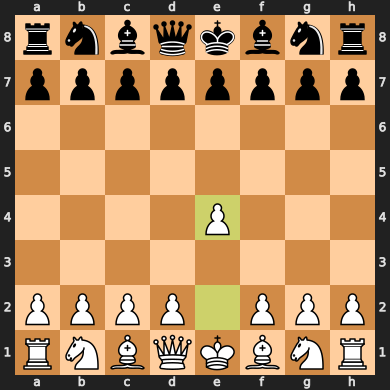

0-1


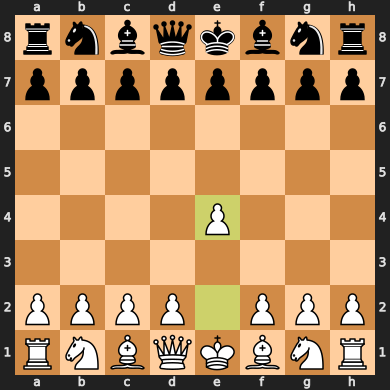

1/2-1/2


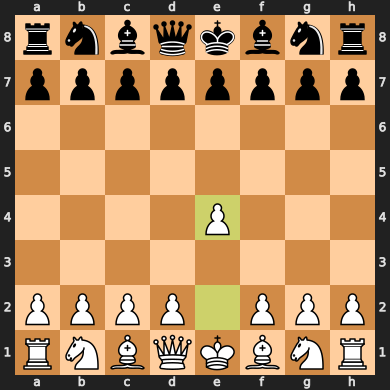

1/2-1/2


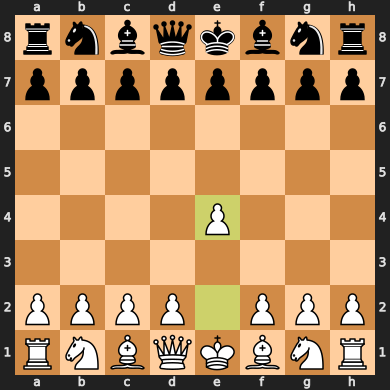

1-0


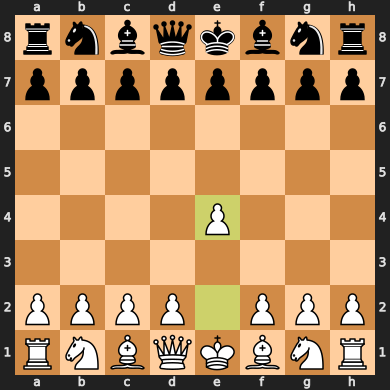

1-0


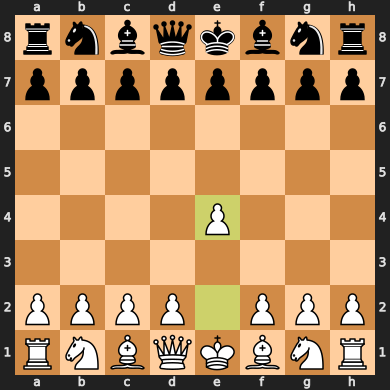

1-0


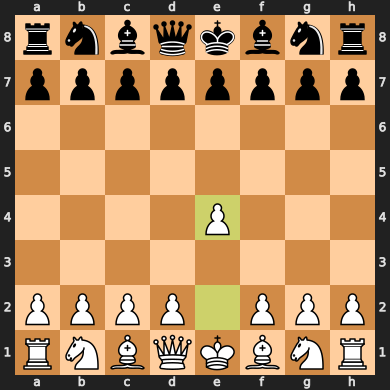

1-0


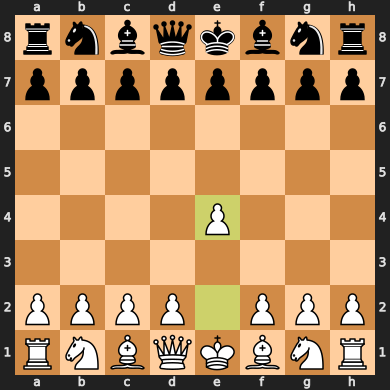

0-1


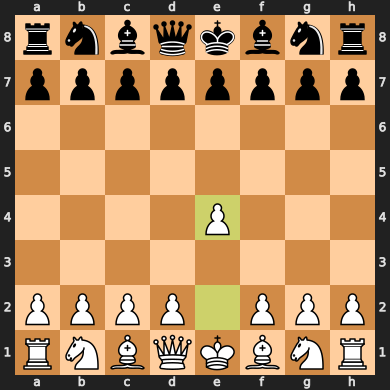

0-1


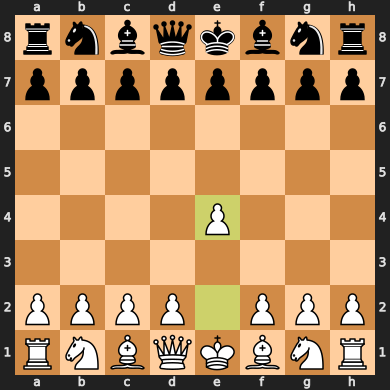

1-0


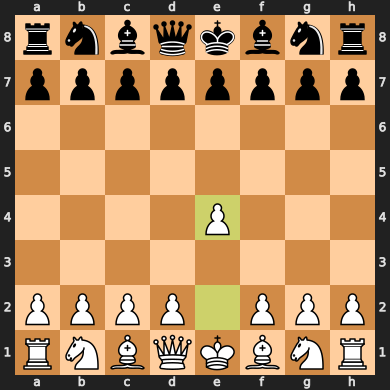

1-0


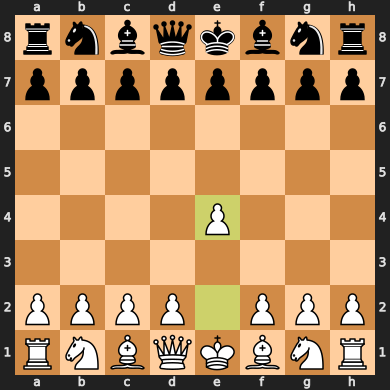

0-1


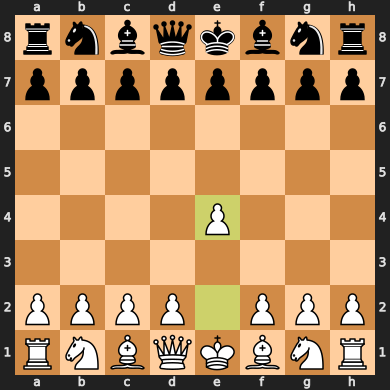

1-0


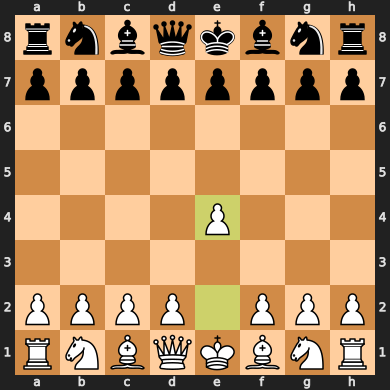

0-1


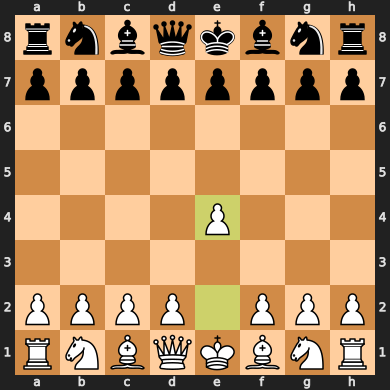

1/2-1/2


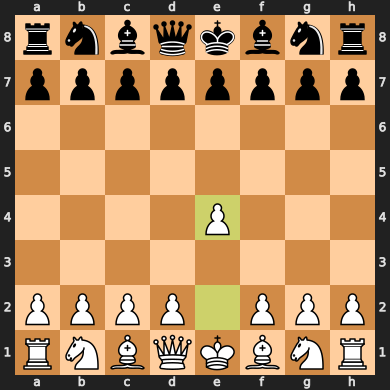

1-0


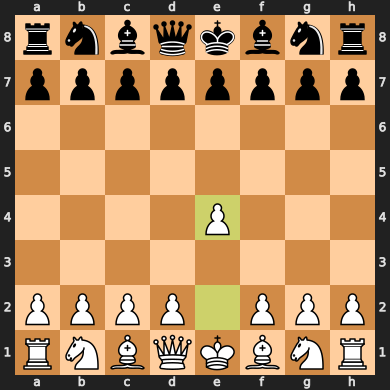

0-1


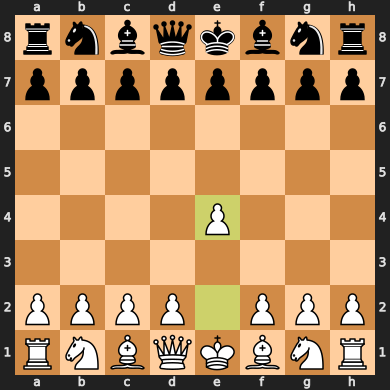

1-0


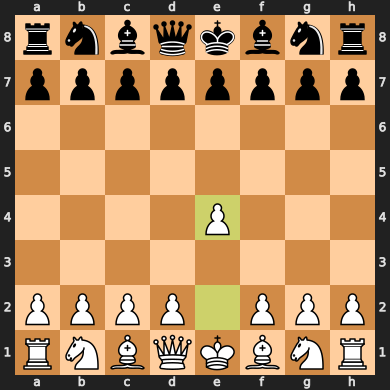

1/2-1/2


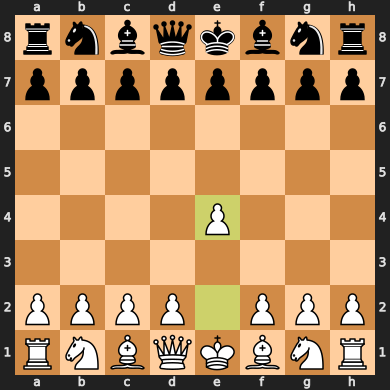

1-0


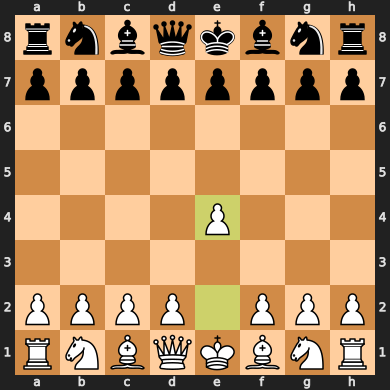

1-0


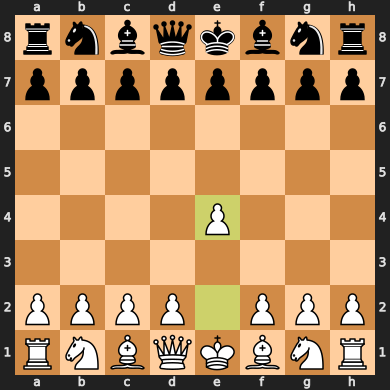

1-0


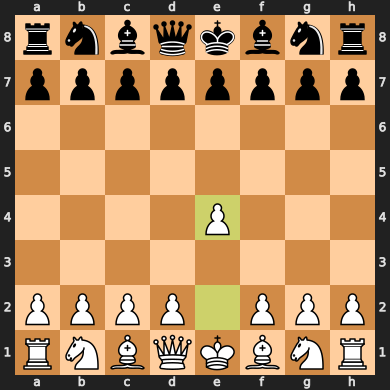

0-1


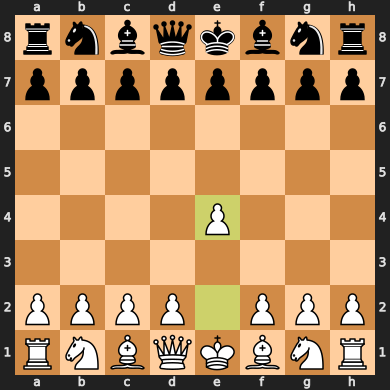

0-1


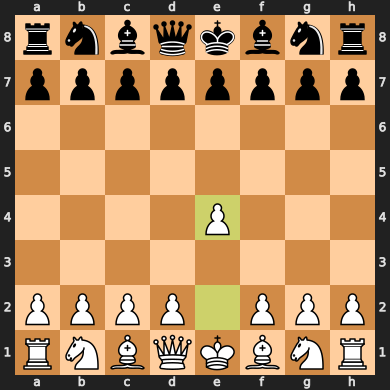

0-1


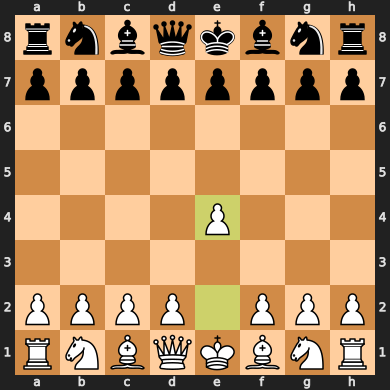

1/2-1/2


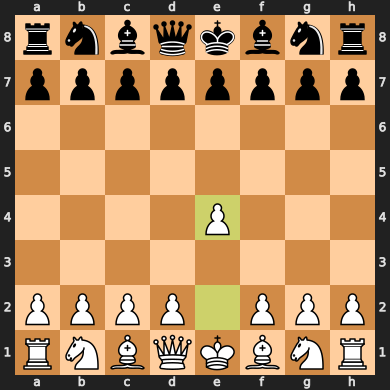

1-0


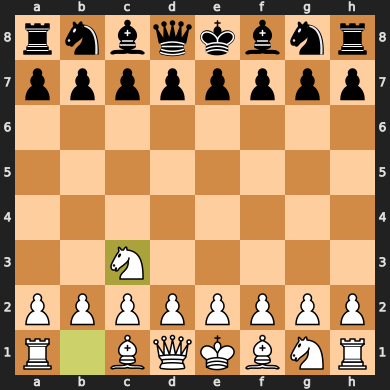

1/2-1/2


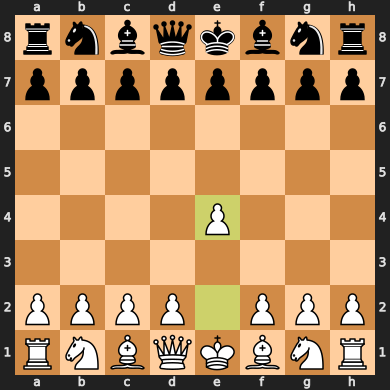

1-0


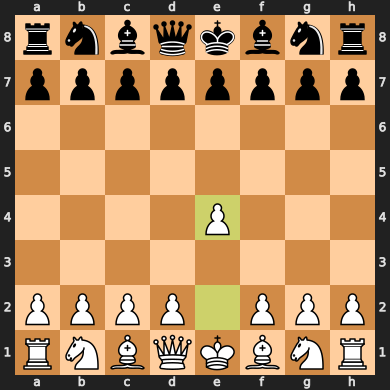

1-0


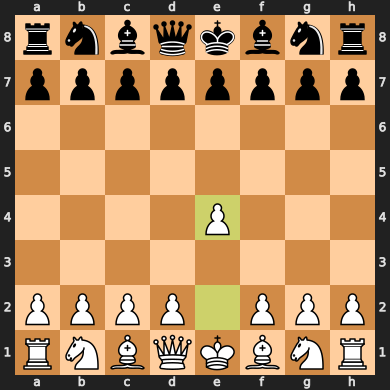

1-0


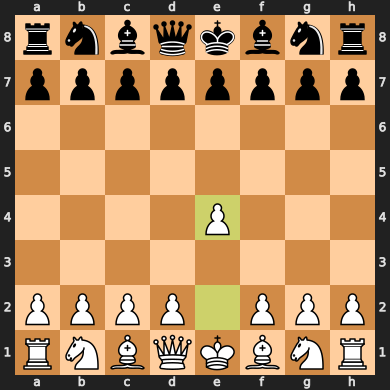

1/2-1/2


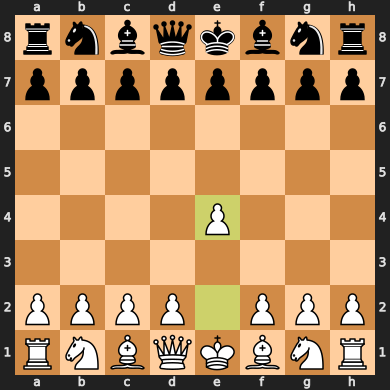

1/2-1/2


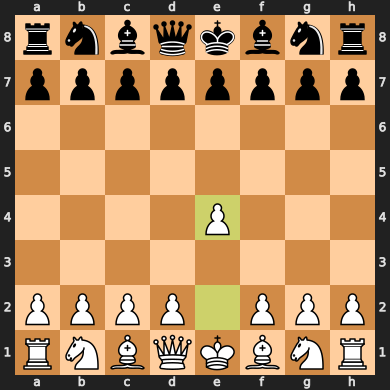

1/2-1/2


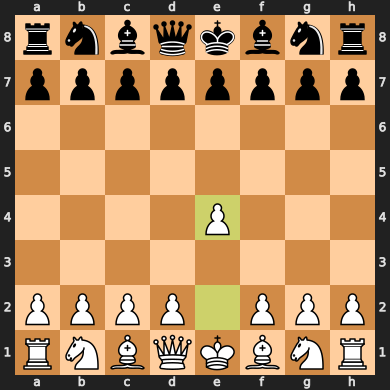

1/2-1/2


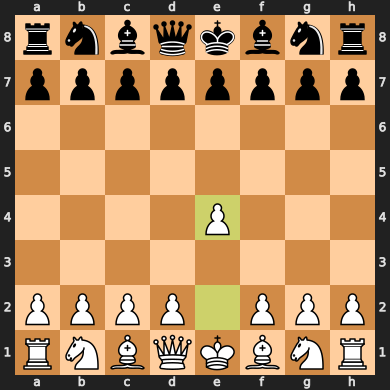

1/2-1/2


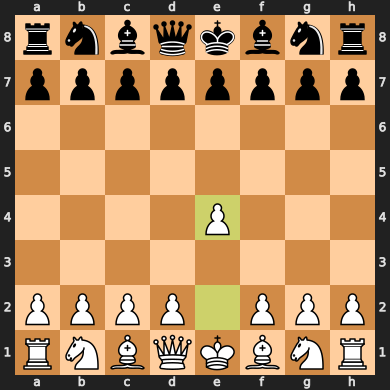

1-0


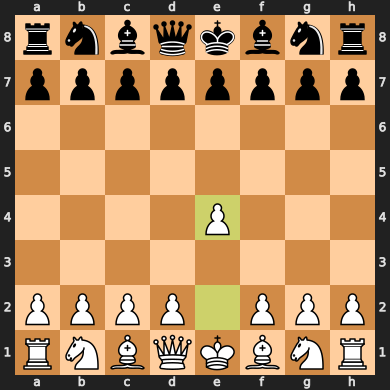

1/2-1/2


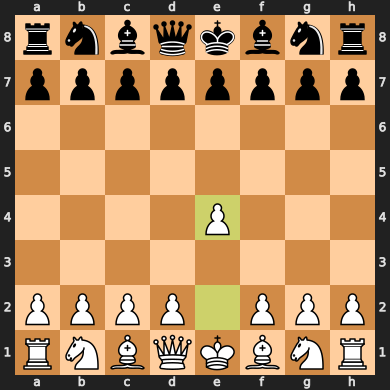

1-0


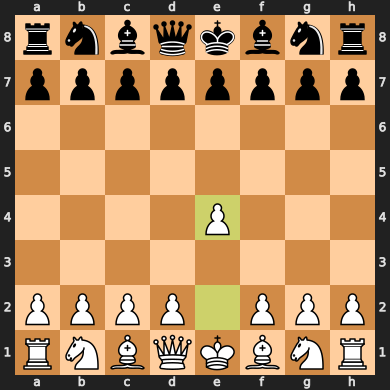

1/2-1/2


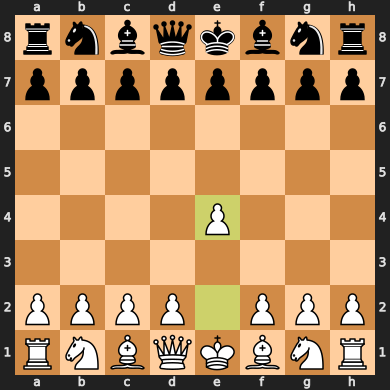

1/2-1/2


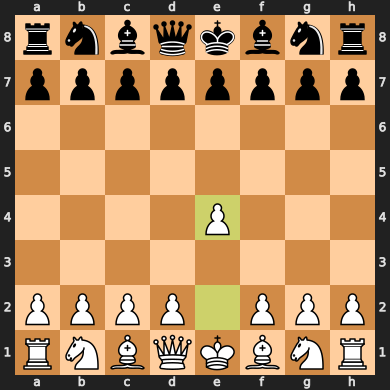

1-0


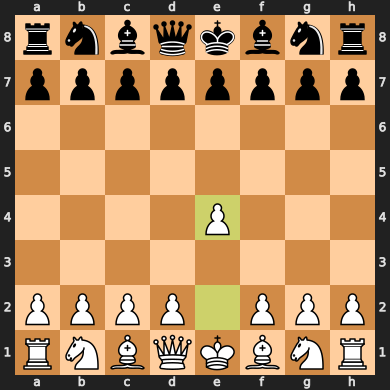

1-0


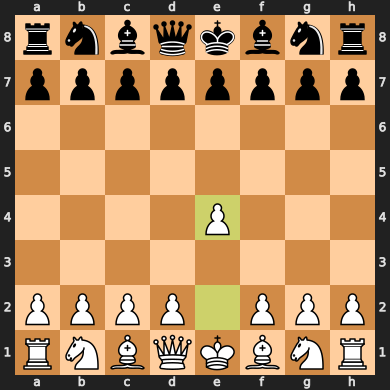

1/2-1/2


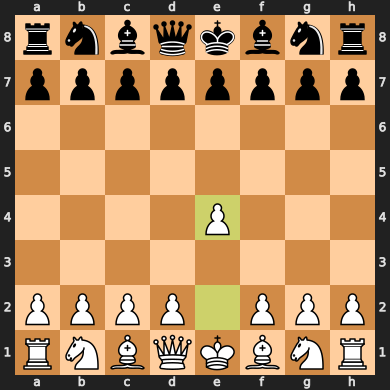

0-1


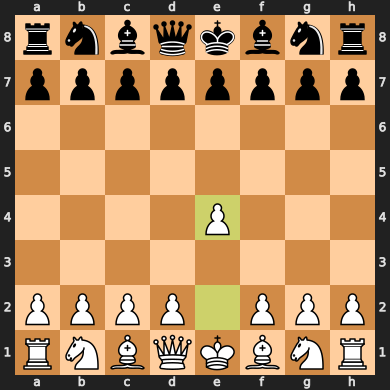

1-0


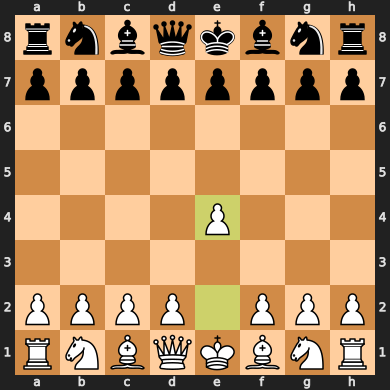

1-0


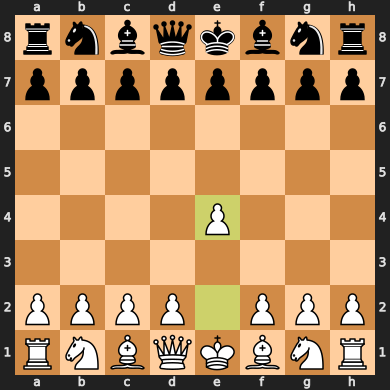

1/2-1/2


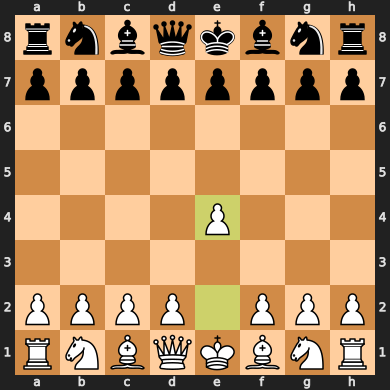

1/2-1/2


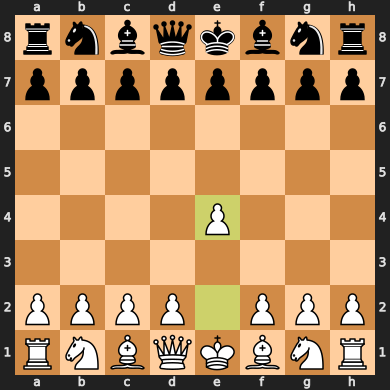

1-0


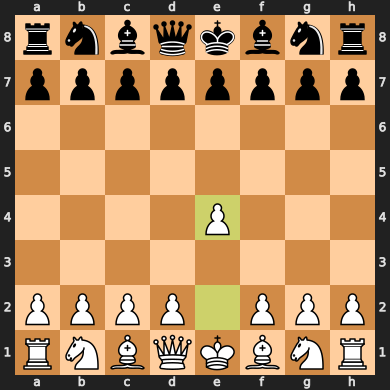

1-0


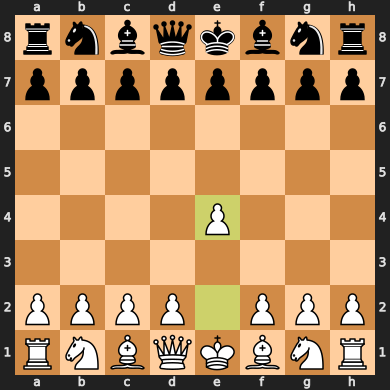

1-0


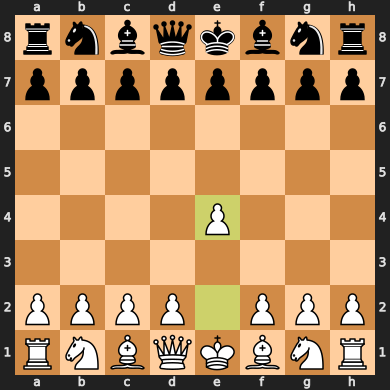

1/2-1/2


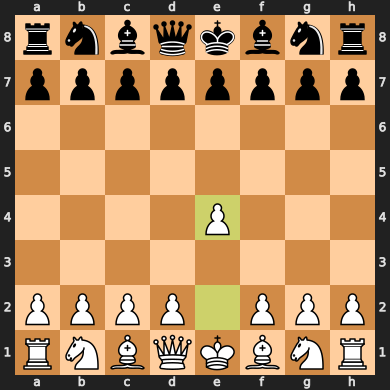

1-0


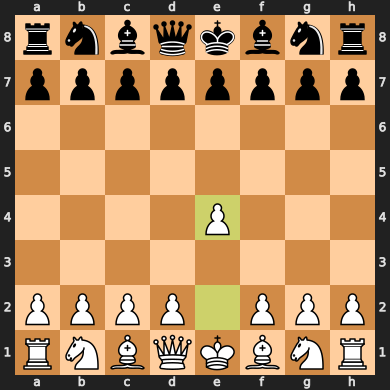

1-0


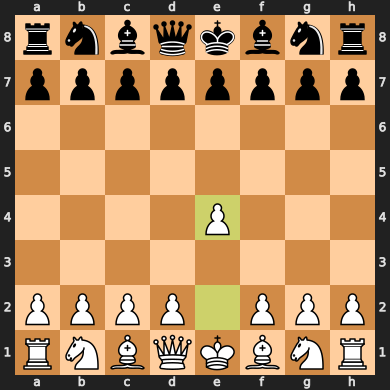

1-0


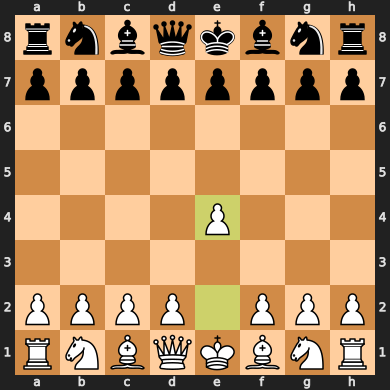

1-0


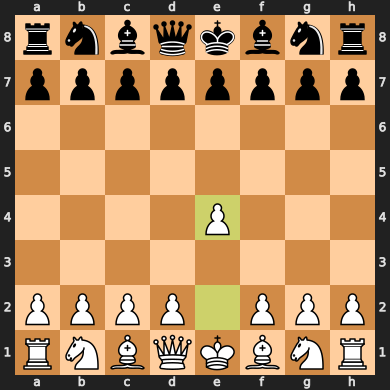

1-0


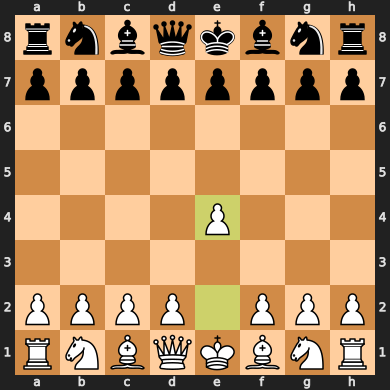

In [25]:
for i in range(100):
    results_game(1)

In [26]:
#searching winnning game

pgn = open_test_pgn()



def parse_one_game(diz,depth):
    new_game = chess.pgn.read_game(pgn)
    
    if new_game == None:
        return

    new_position = new_game

    for move in new_game.mainline_moves():  
        print("-------")
        print("New position")
        new_position = new_position.variation(move)
        
        print(new_position.game().headers['Result'])
        print(new_position.game().headers['Result'])
        
        print(new_position.board().fen())
        
        
        new_id = gamenode_to_id(new_position)

        if new_id in diz.keys():
            diz[new_id].update(new_position)
        else:
            diz[new_id] = MyGame(new_position)

        pos = diz[new_id]
        print("Multiplicity")
        print(pos.multiplicity)
        print("White wins")
        print(pos.white_wins)
        #print("Position result")
        #print(pos.result)
        
        if new_position.ply() == depth:
            break
            
def parse_few_games(depth,how_many):
    dizio = {}
    for i in range(how_many):
        parse_one_game(dizio,depth)
    

In [27]:
parse_few_games(3,10)

-------
New position
1-0
1-0
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
Multiplicity
1
White wins
1
-------
New position
1-0
1-0
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
Multiplicity
1
White wins
1
-------
New position
1-0
1-0
rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR b KQkq - 1 2
Multiplicity
1
White wins
1
-------
New position
0-1
0-1
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
Multiplicity
2
White wins
1
-------
New position
0-1
0-1
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
Multiplicity
2
White wins
1
-------
New position
0-1
0-1
rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQKBNR b KQkq - 1 2
Multiplicity
2
White wins
1
-------
New position
1-0
1-0
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
Multiplicity
3
White wins
2
-------
New position
1-0
1-0
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
Multiplicity
3
White wins
2
-------
New position
1-0
1-0
rnbqkbnr/pppp1ppp/8/4p3/4P3/2